This project is about building a model to predict resale cost of used cars in major cities in india. Dataset used here is from hackathon hosted by [MachineHack](https://www.machinehack.com/) Go to hackathon [homepage](https://www.machinehack.com/course/predicting-the-costs-of-used-cars-hackathon-by-imarticus/) to know more about dataset.

# Used Cars Price Predictions 

## Loading data and packages

In [12]:
%load_ext autoreload
%autoreload 2
%autosave 5

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import multiprocessing as mp
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import scipy as sp
from scipy import stats
import itertools
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.stats import shapiro, anderson, f_oneway
from scipy.spatial.distance import mahalanobis
from category_encoders import *
#import h2o4gpu as sklearn
import pickle
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.feature_selection import SelectKBest, chi2
from modules.custom_transformers import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler, Normalizer, normalize)
from sklearn.linear_model import LinearRegression,ridge_regression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score, mean_squared_log_error
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


warnings.filterwarnings('ignore')


%matplotlib inline
sns.set() # setting seaborn default for plots


train = pd.read_excel(r'./DataSets/Data_Train.xlsx')
test = pd.read_excel(r'./DataSets/Data_Test.xlsx')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 5 seconds


In [71]:
training_set = train.copy()
test_set = test.copy()

### Seting parameters

In [2]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [14]:
training_set.head()

Name    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010              72000   
1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015              41000   
2                      Honda Jazz V     Chennai  2011              46000   
3                 Maruti Ertiga VDI     Chennai  2012              87000   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013              40670   

  Fuel_Type Transmission Owner_Type     Mileage   Engine      Power  Seats  \
0       CNG       Manual      First  26.6 km/kg   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First  19.67 kmpl  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.2 kmpl  1199 CC   88.7 bhp    5.0   
3    Diesel       Manual      First  20.77 kmpl  1248 CC  88.76 bhp    7.0   
4    Diesel    Automatic     Second   15.2 kmpl  1968 CC  140.8 bhp    5.0   

   New_Price  Price  
0        NaN   1.75  
1        NaN  12.50  
2  8.61 Lakh   4.50  
3        NaN   6.00  
4        NaN  17.74

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5876 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


 Dataset used here is from a hackathon hosted by MachineHack. Dataset contains around 6000 cars examples and has features like Location, Manufacture details, car features such as Fuel type, Engine, and usage parameters. sample is shown here. Some features are numeric attached with units and they need to be removed

In [31]:
print('\nNo of features in Trainset:', train.shape[1])
print('\nNo of features in Testset:', test.shape[1])

print('\nfeatures in Trainset:\n-', '\n- '.join(list(train.columns)))
print('\nfeatures in Testset:\n-', '\n- '.join(list(test.columns)))

print('\nfeatures datatypes in Trainset:\n', train.dtypes)
print('\nfeatures datatypes in Testset:\n', test.dtypes)

print('\nEmpty cells in the TrainSet:\n', train.isnull().values.sum())
print('\nEmpty cells in the TestSet:\n', test.isnull().values.sum())


No of features in Trainset: 13

No of features in Testset: 12

features in Trainset:
- Name
- Location
- Year
- Kilometers_Driven
- Fuel_Type
- Transmission
- Owner_Type
- Mileage
- Engine
- Power
- Seats
- New_Price
- Price

features in Testset:
- Name
- Location
- Year
- Kilometers_Driven
- Fuel_Type
- Transmission
- Owner_Type
- Mileage
- Engine
- Power
- Seats
- New_Price

features datatypes in Trainset:
 Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

features datatypes in Testset:
 Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission     

In [32]:
# lets count uniques values in each column
unique_cnt = list(map(lambda x: len(training_set[x].unique()), list(training_set)))
print('unique counts in each column:')
dict(zip(list(training_set),unique_cnt))

unique counts in each column:


{'Name': 1876,
 'Location': 11,
 'Year': 22,
 'Kilometers_Driven': 3093,
 'Fuel_Type': 5,
 'Transmission': 2,
 'Owner_Type': 4,
 'Mileage': 443,
 'Engine': 147,
 'Power': 372,
 'Seats': 10,
 'New_Price': 541,
 'Price': 1373}

In [33]:
#combining training set and test set data
all_brands = list(training_set.Name) + list(test_set.Name)
all_locations = list(training_set.Location) + list(test_set.Location)
all_fuel_types = list(training_set.Fuel_Type) + list(test_set.Fuel_Type)
all_transmissions = list(training_set.Transmission) + list(test_set.Transmission)
all_owner_types = list(training_set.Owner_Type) + list(test_set.Owner_Type)

print("\nNumber Of Unique Values In Name : \n ", len(set(all_brands)))
#print("\nThe Unique Values In Name : \n ", set(all_brands))

print("\nNumber Of Unique Valuesa In Location : \n ", len(set(all_locations)))
print("\nThe Unique Values In Location : \n ", set(all_locations) )

print("\nNumber Of Unique Values In Fuel_Type : \n ", len(set(all_fuel_types)))
print("\nThe Unique Values In Fuel_Type : \n ", set(all_fuel_types) )

print("\nNumber Of Unique Values In Transmission : \n ", len(set(all_transmissions)))
print("\nThe Unique Values In Transmission : \n ", set(all_transmissions) )

print("\nNumber Of Unique Values In Owner_Type : \n ", len(set(all_owner_types)))
print("\nThe Unique Values In Owner_Type : \n '' ",set(all_owner_types))


Number Of Unique Values In Name : 
  2041

Number Of Unique Valuesa In Location : 
  11

The Unique Values In Location : 
  {'Delhi', 'Hyderabad', 'Mumbai', 'Coimbatore', 'Bangalore', 'Kochi', 'Ahmedabad', 'Jaipur', 'Chennai', 'Kolkata', 'Pune'}

Number Of Unique Values In Fuel_Type : 
  5

The Unique Values In Fuel_Type : 
  {'Diesel', 'LPG', 'Electric', 'Petrol', 'CNG'}

Number Of Unique Values In Transmission : 
  2

The Unique Values In Transmission : 
  {'Automatic', 'Manual'}

Number Of Unique Values In Owner_Type : 
  4

The Unique Values In Owner_Type : 
 ''  {'Second', 'First', 'Third', 'Fourth & Above'}


### Data Cleaning

In [34]:
def F_Clean(x):
    try:
        return x.split(' ')[0].strip()
    except:
        return np.nan
    
# Remove unites from Milage and covert to float 
training_set['Mileage'] = [float(F_Clean(i)) for i in training_set.Mileage]
test_set['Mileage'] = [float(F_Clean(i)) for i in test_set.Mileage]

# Remove units from Engine and covert to strings 
training_set['Engine'] = [float(F_Clean(i)) for i in training_set.Engine]
test_set['Engine'] = [float(F_Clean(i)) for i in test_set.Engine]

training_set['Power'] = [float(F_Clean(i)) for i in training_set.Power]
test_set['Power'] = [float(F_Clean(i)) for i in test_set.Power]

# Drop New_price feature as it contians significant null values
training_set.drop(labels=['New_Price'],axis=1,inplace=True)
test_set.drop(labels=['New_Price'],axis=1,inplace=True)

## Data Exploration

### Univariate Analysis

#### Name

In [17]:
training_set = pd.read_csv('DataSets/TrainSet_Cleaned.csv')

Top 10 cars:

Mahindra XUV500 W8 2WD        49
Maruti Swift VDI              45
Maruti Swift Dzire VDI        34
Honda City 1.5 S MT           34
Maruti Swift VDI BSIV         31
Maruti Ritz VDi               30
Hyundai i10 Sportz            30
Toyota Fortuner 3.0 Diesel    29
Hyundai Grand i10 Sportz      27
Honda Amaze S i-Dtech         27
Name: Name, dtype: int64


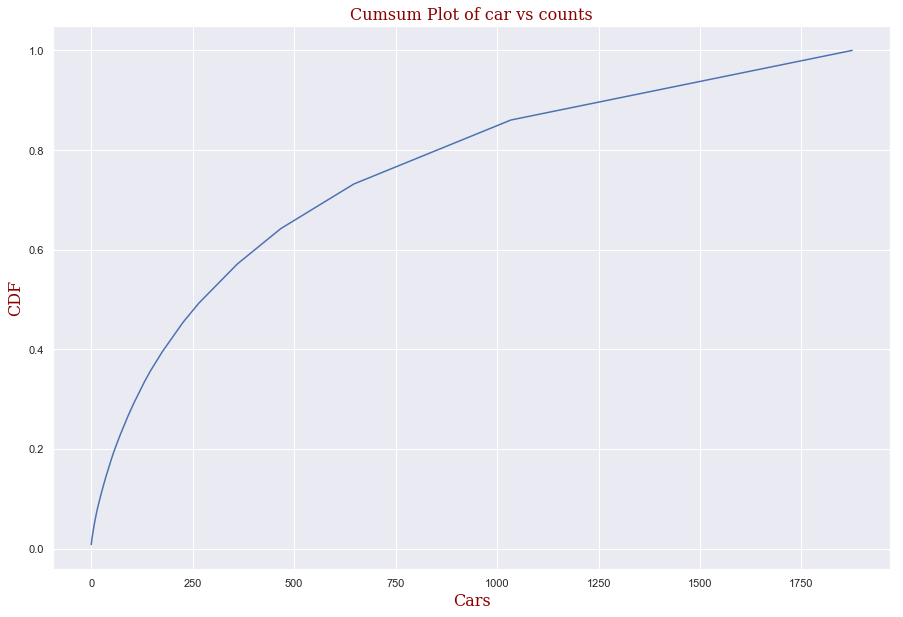

In [21]:
# Cumsum plot to see decide cutoff point

print("Top 10 cars:\n")
print(training_set.Name.value_counts().head(10))
      
y = training_set.Name.value_counts(normalize=True).cumsum()
x = len(y)

plt.figure(figsize=(15,10))
plt.plot(range(x),y);
plt.title('Cumsum Plot of car vs counts', fontdict = font)
plt.xlabel('Cars', fontdict = font)
plt.ylabel('CDF', fontdict = font);

* There are over 1800 varities of cars. Some are widely owned and some are rare
* Roughly, 800 cars makes up 80% and rest 1000 only occupies 20%
* There are lot of categoreies in this to handle, we deal with later.

#### Split name into Brand + Model  

If we observe the cars name, First word in the Names corressponds to Brand and rest of it corresponds to Model name, series. Along with "brand" we need to decide how many words to keep after Brand which makes Model feature.

In [100]:
print("Max length available for assigning Model:")
print(min(list(map(lambda x: len(x.split(' ')), training_set.Name)))-1) # -1 as first word dedicated to Brand 

Max length available for assigning Model:
2


We could use combined second and third word (upto 2 words) for Model feature.

In [102]:
# no of uniques when when only 2nd variable is considered

print("no of uniques when when only 2nd word is considered:")
print(len(set([i.split(' ')[1].strip() for i in training_set.Name])))

print("no of uniques when 2nd and 3rd word is considered:")
print(len(set([' '.join(i.split(' ')[1:3]).strip() for i in training_set.Name])))


no of uniques when when only 2nd word is considered:
212
no of uniques when 2nd and 3rd word is considered:
689


Lets see how many categories we get upon adding 2nd word alone and 2nd and 3rd word together.

- no of unique values when when only 2nd word is considered: 212
- no of unique values when 2nd and 3rd word is considered together: 689

We will have lot of actgories if we go with 2nd and 3rd combined therefore I used only second word of Model feature 

#### Analyse Distribution brand and model 

In [105]:
# Split Car name feature into Brand and Model features for both sets 
Brands = training_set.Name.apply(lambda x: x.split(' ')[0])
Models = training_set.Name.apply(lambda x: x.split(' ')[1])

Top 10 Brands:

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Name: Name, dtype: int64
Top 10 Models:

Swift     353
City      270
i20       247
Verna     170
Innova    164
Grand     156
i10       156
Wagon     154
Polo      151
Alto      143
Name: Name, dtype: int64


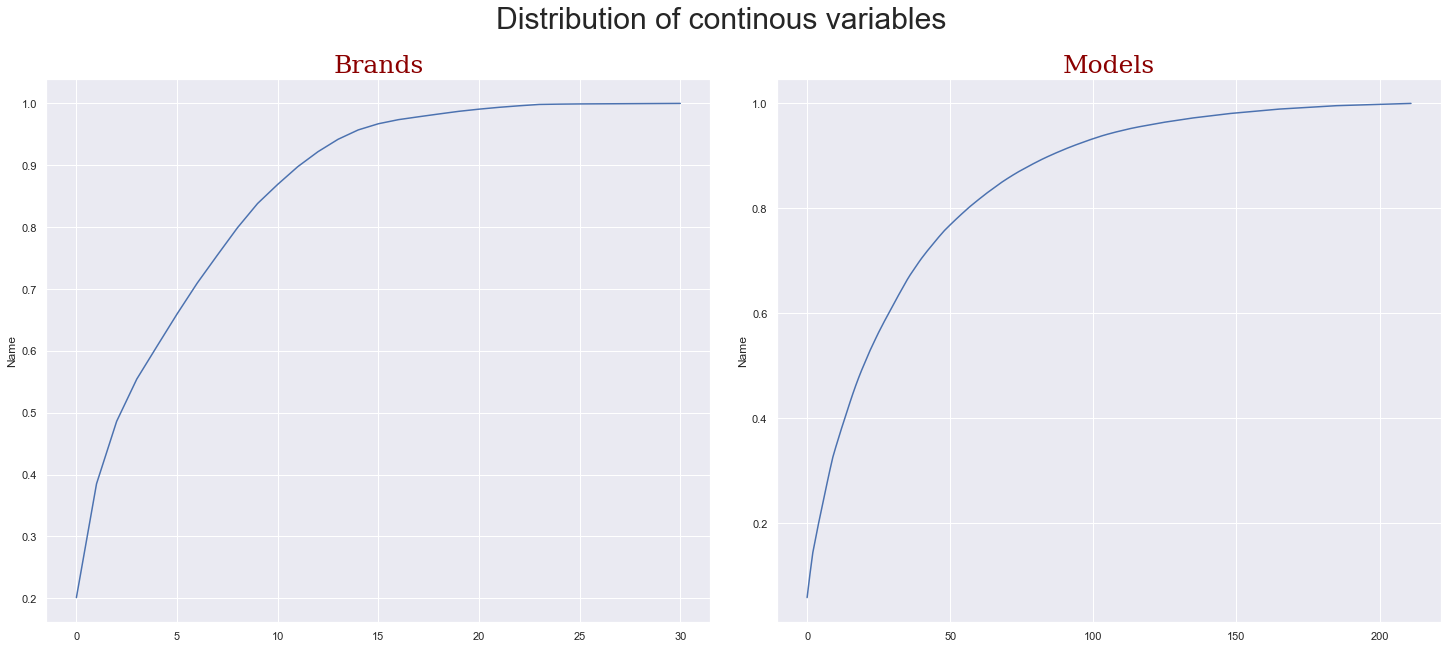

In [128]:
print("Top 10 Brands:\n")
print(Brands.value_counts().head(10))

print("Top 10 Models:\n")
print(Models.value_counts().head(10))
      
y = training_set.Name.value_counts(normalize=True).cumsum()
x = len(y)

fig,axes = plt.subplots(1,2,figsize=(25,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,var in enumerate([Brands, Models]):
    y = var.value_counts(normalize=True).cumsum()
    sns.lineplot(x=range(len(y)), y=y, ax = axes[i]);
    plt.title('Cumsum Plot of car vs counts', fontdict = font)
    axes[i].set_title(['Brands', 'Models'][i],fontdict = font, fontsize=25)


* Just 8 Brands make up 80% and rest occupies only 20%
* Roughly, 55 Models make up 80% and rest occupies 20%

#### Categorical and ordinal variables

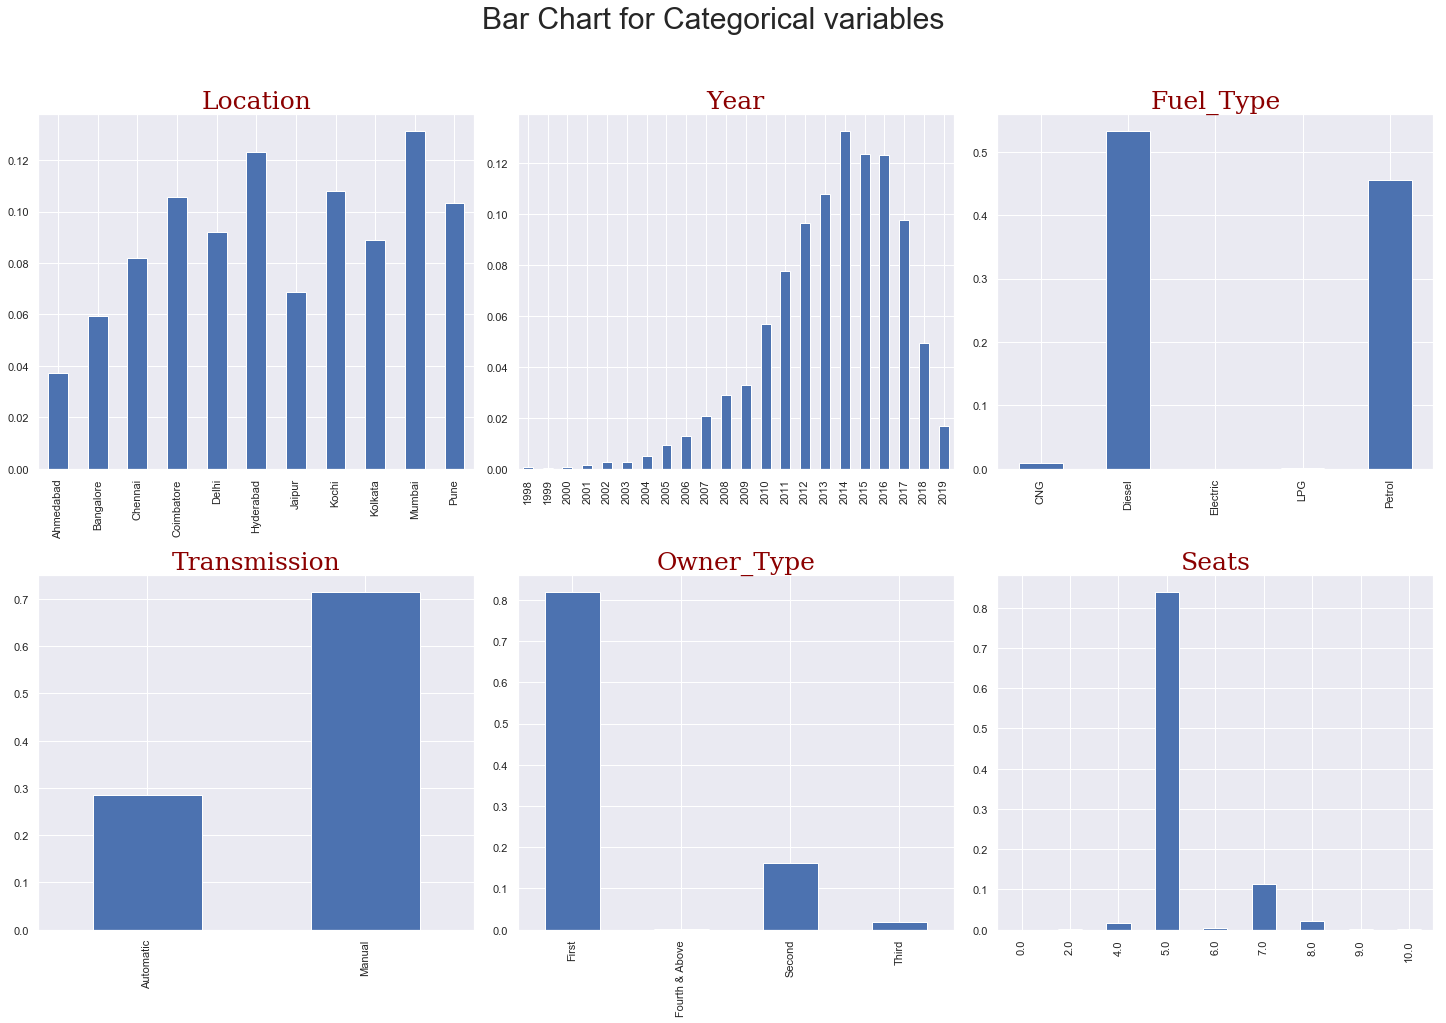

In [50]:
cat_cols = ['Location','Year', 'Fuel_Type','Transmission', 'Owner_Type','Seats']
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Bar Chart for Categorical variables', fontsize=30)
axes = axes.ravel()


for i,col in enumerate(cat_cols):
    training_set[col].value_counts(normalize=True, sort=False).sort_index(ascending=True)
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
    axes[i].xaxis.get_label().set_fontsize(20)
    #axes[i].axis('off')
#fig.delaxes(axes[-1])
#fig.delaxes(axes[-2])

1. Location: 
     * Mumbai has highest cars sellers and Amdhabad has least with no significant count diffenerce across categories. One Hot encoding would add 22 extra features, May be mean encoding could be used but confirmed if we find price distribution across cities.
2. Year:
    * Recent years has high contributon i.e models manufactered over this period are high traded. Since variable is ordinal encoded we could tranform by curr_year(2019)-year meaning older the car more is drepriciation.
3. Fuel_type:
    *  Desiel and Petrol contitutes more. Onhot-encoding only for Desiel and pentrol would work fine.
5. OWner_type
    * First time owners are more about 90%. one hot encoding for fist two categories would work.
6. Seats
    * Most cars are 5 seaters.

#### Countinous variable

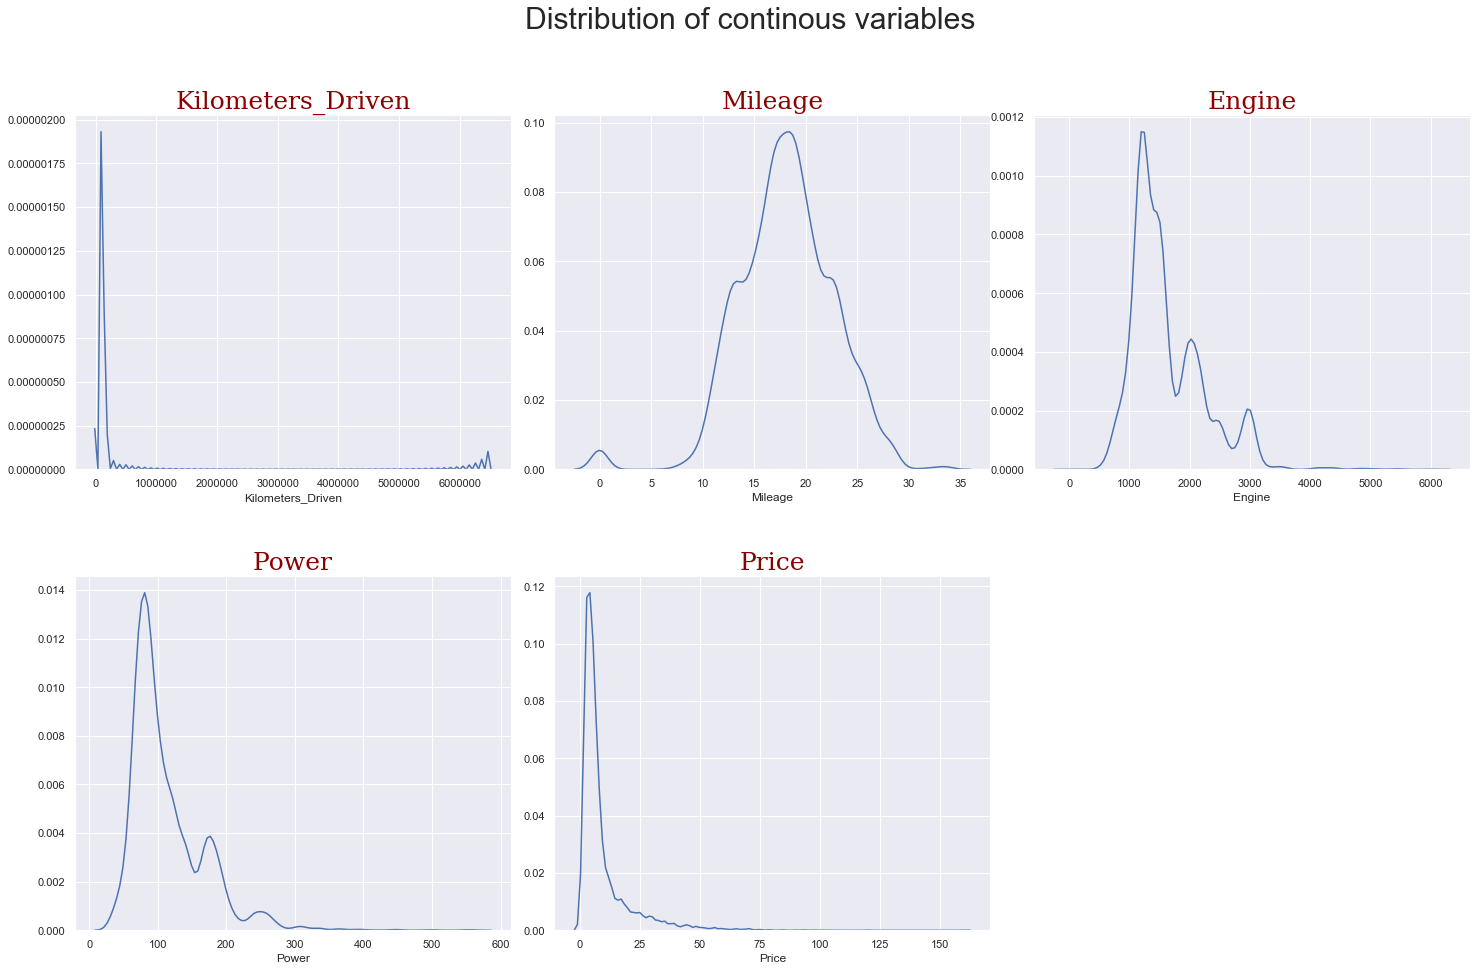

In [85]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    sns.distplot((training_set[col][~pd.isna(training_set[col])]), hist= False,ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

Except Milage feature, rest are highly positive skewed including target variable. Let look at Q-Q plot that checks normality.


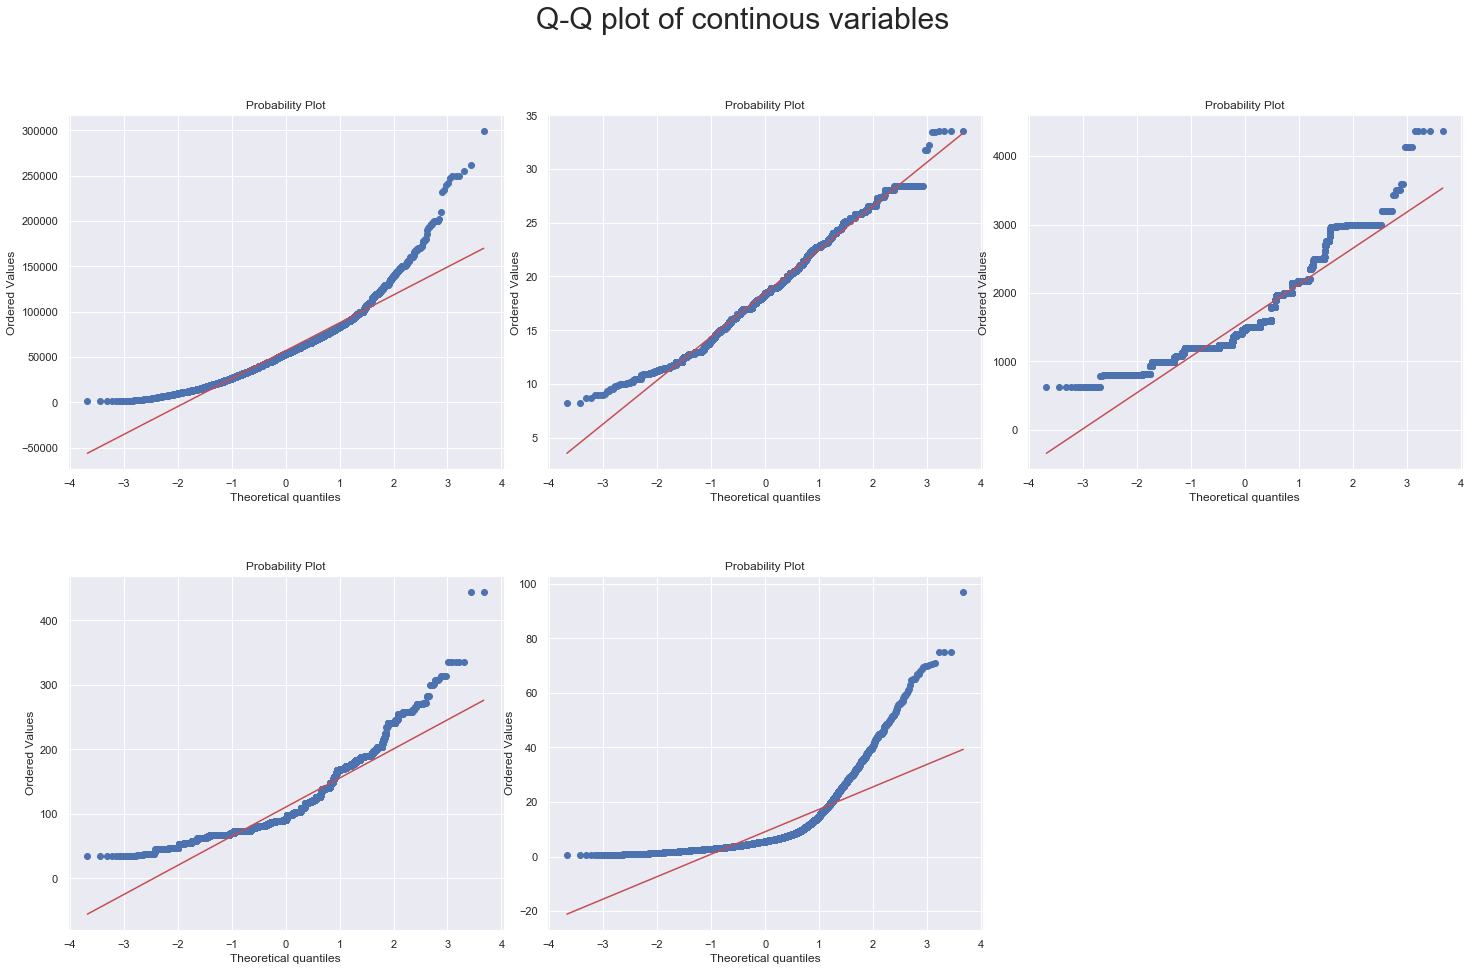

In [42]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Q-Q plot of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    res = stats.probplot((training_set[col][~pd.isna(training_set[col])]), plot=axes[i])
fig.delaxes(axes[-1])

From the above plot it is evident that features are not normally distributed. If we intend to fit data to non-tree based ML models like Linear regression we need remove skewness in the data and make transform them to closely follow normal distribution.

Lets create the above two plots with log transformation.



##### Countinous variable with log applied

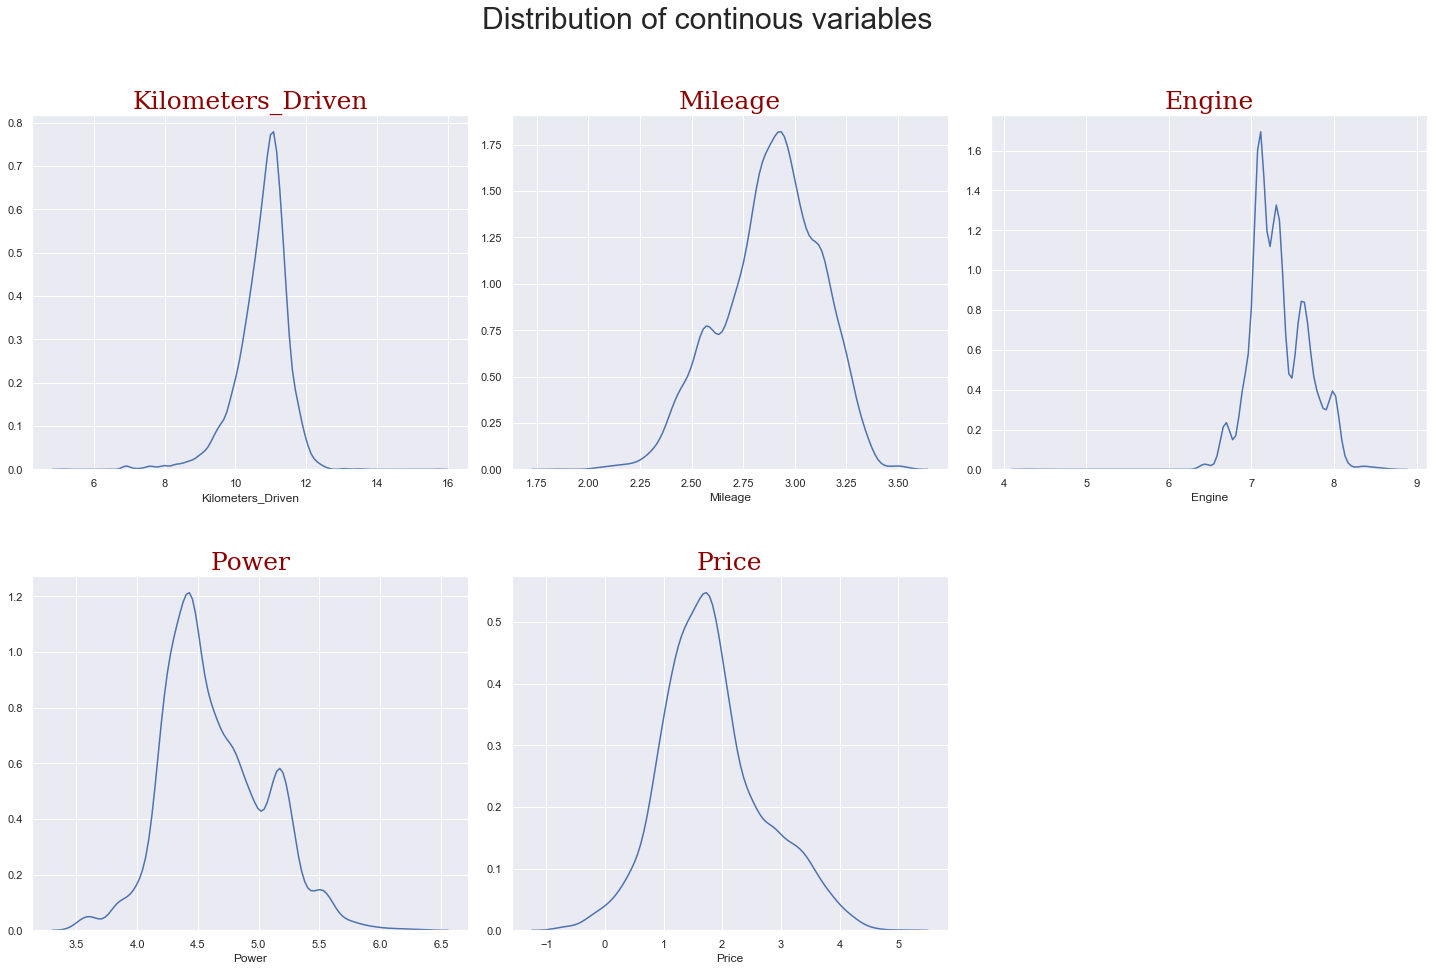

In [86]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    sns.distplot((training_set[col][~pd.isna(training_set[col])]).apply(np.log), hist= False,ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

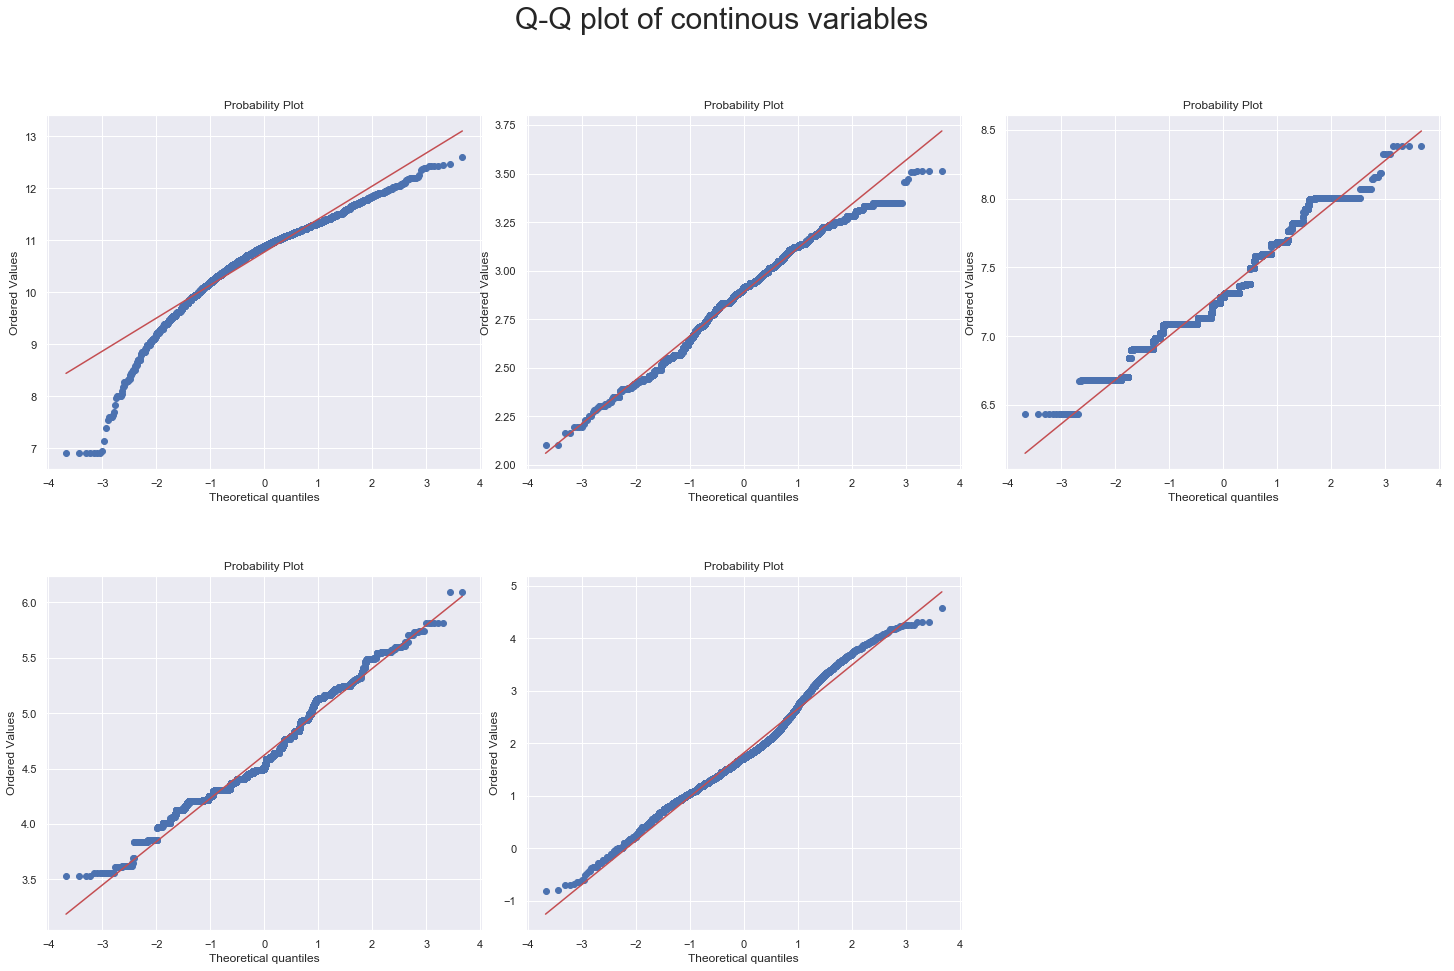

In [41]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Q-Q plot of Log transformed variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    res = stats.probplot((training_set[col][~pd.isna(training_set[col])]).apply(np.log), plot=axes[i])
fig.delaxes(axes[-1])

Log tranformed features looks better in shape compared to original form.

#### OutLier Detection

##### Uni - variate

In [51]:
list(itertools.combinations(con_cols, 2))

[('Kilometers_Driven', 'Mileage'),
 ('Kilometers_Driven', 'Engine'),
 ('Kilometers_Driven', 'Power'),
 ('Kilometers_Driven', 'Price'),
 ('Mileage', 'Engine'),
 ('Mileage', 'Power'),
 ('Mileage', 'Price'),
 ('Engine', 'Power'),
 ('Engine', 'Price'),
 ('Power', 'Price')]

NameError: name 'font' is not defined

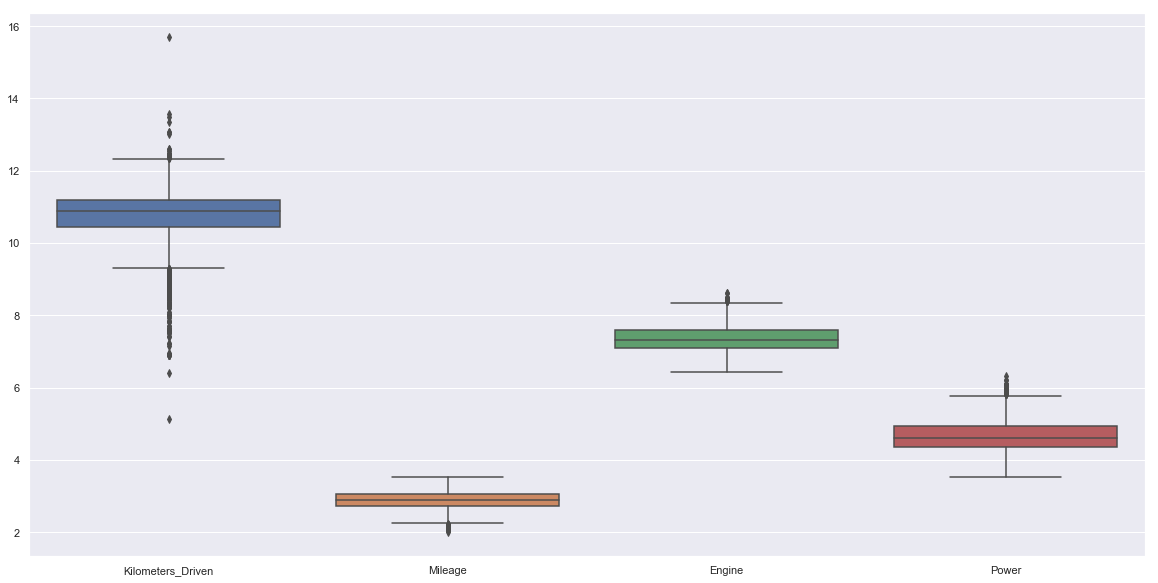

In [27]:
plt.figure(figsize=(20,10))

# Log tranformation
sns.boxplot(data=training_set[con_cols].apply(np.log));
plt.title("Box plot of "+", ".join(con_cols), fontdict = font);

##### Bi - variate

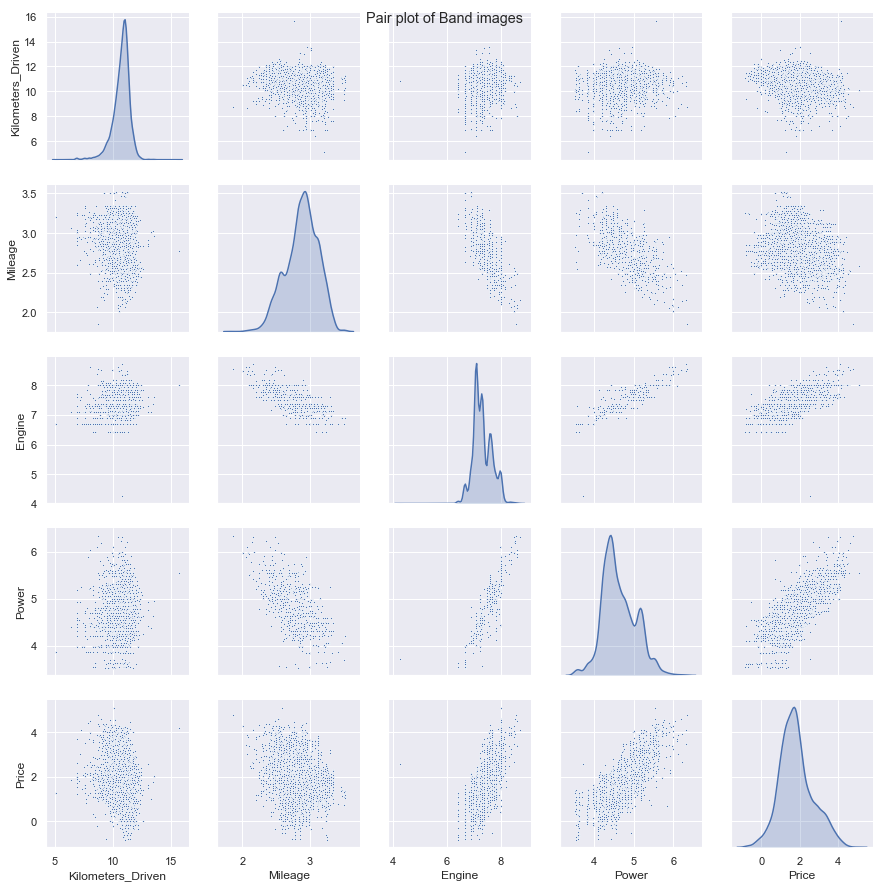

In [77]:

con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]

a = sns.pairplot(data=training_set[con_cols].apply(np.log),
                 diag_kind='kde',plot_kws={"s": 5})
a.fig.suptitle("Pair plot of Band images");


### Bivariate Analysis

#### Brand vs other

'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price']

##### Brand vs Categorical

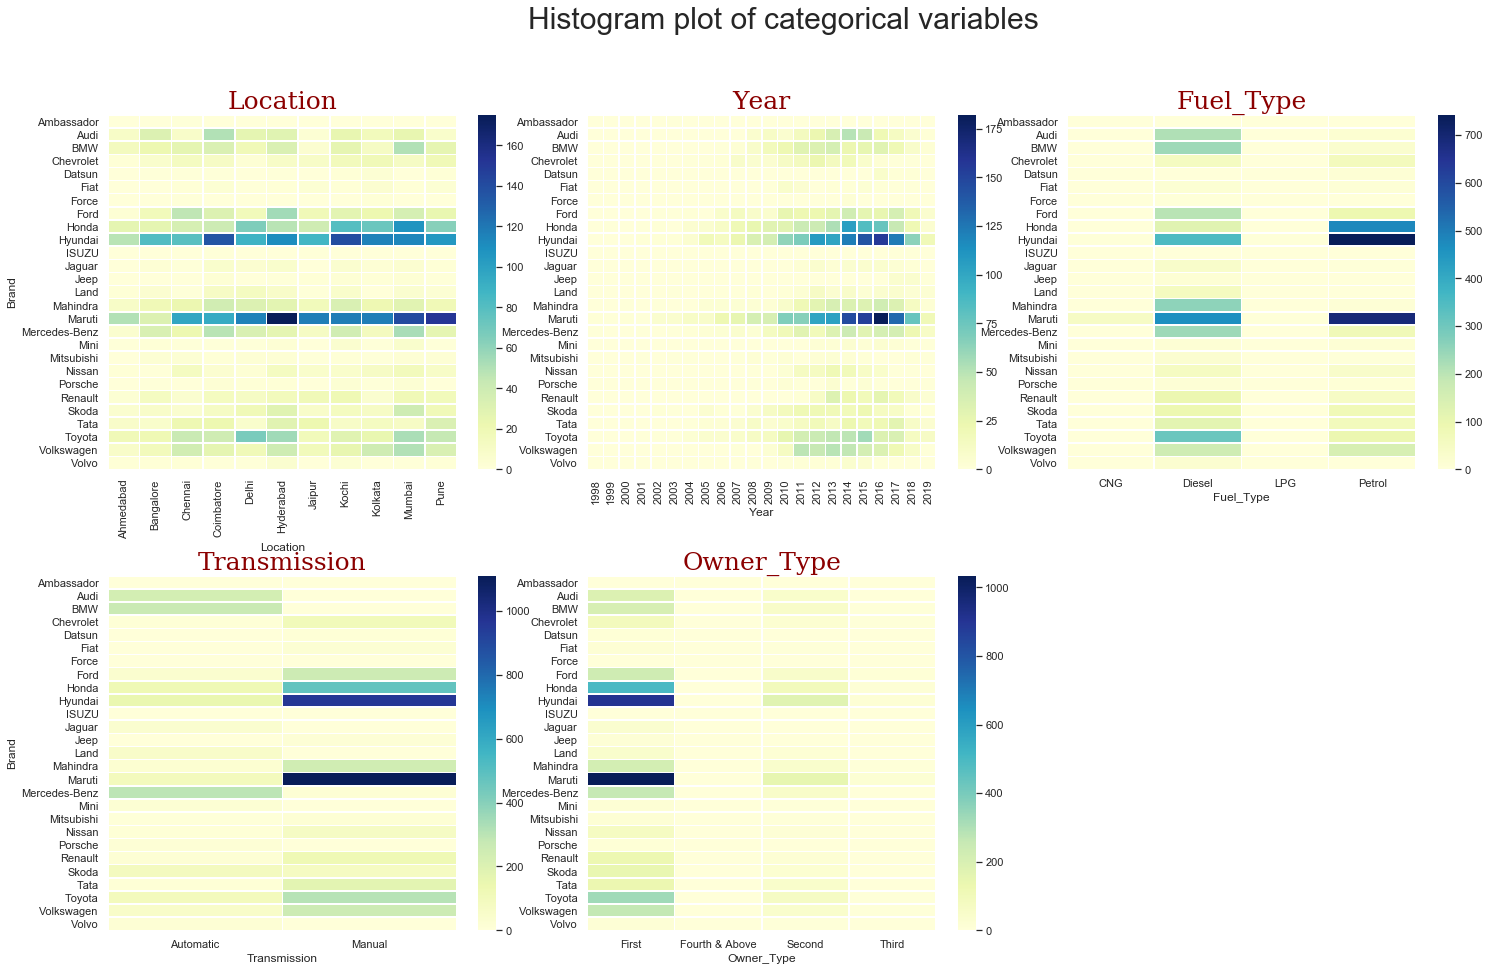

In [16]:
cols = ['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type']

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Histogram plot of categorical variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    tab = pd.crosstab(index=training_set.Brand,columns=training_set[col])
    sns.heatmap(tab,linewidths=0.5,cmap="YlGnBu", ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

* Muruti, Hyundai and Honda remians top brands across major cities in india.

* Majority of cars sold are recently manufactered after 2010, with 2016 year being highest.

* Finding on other features are no different from the one already stated.

Lets take a look at how continous features vary across different brands. I have considered top 8 brands for simplicity as there so many brands.

##### Brand vs Continous

In [55]:
training_set.columns

Index(['Brand', 'Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price'],
      dtype='object')

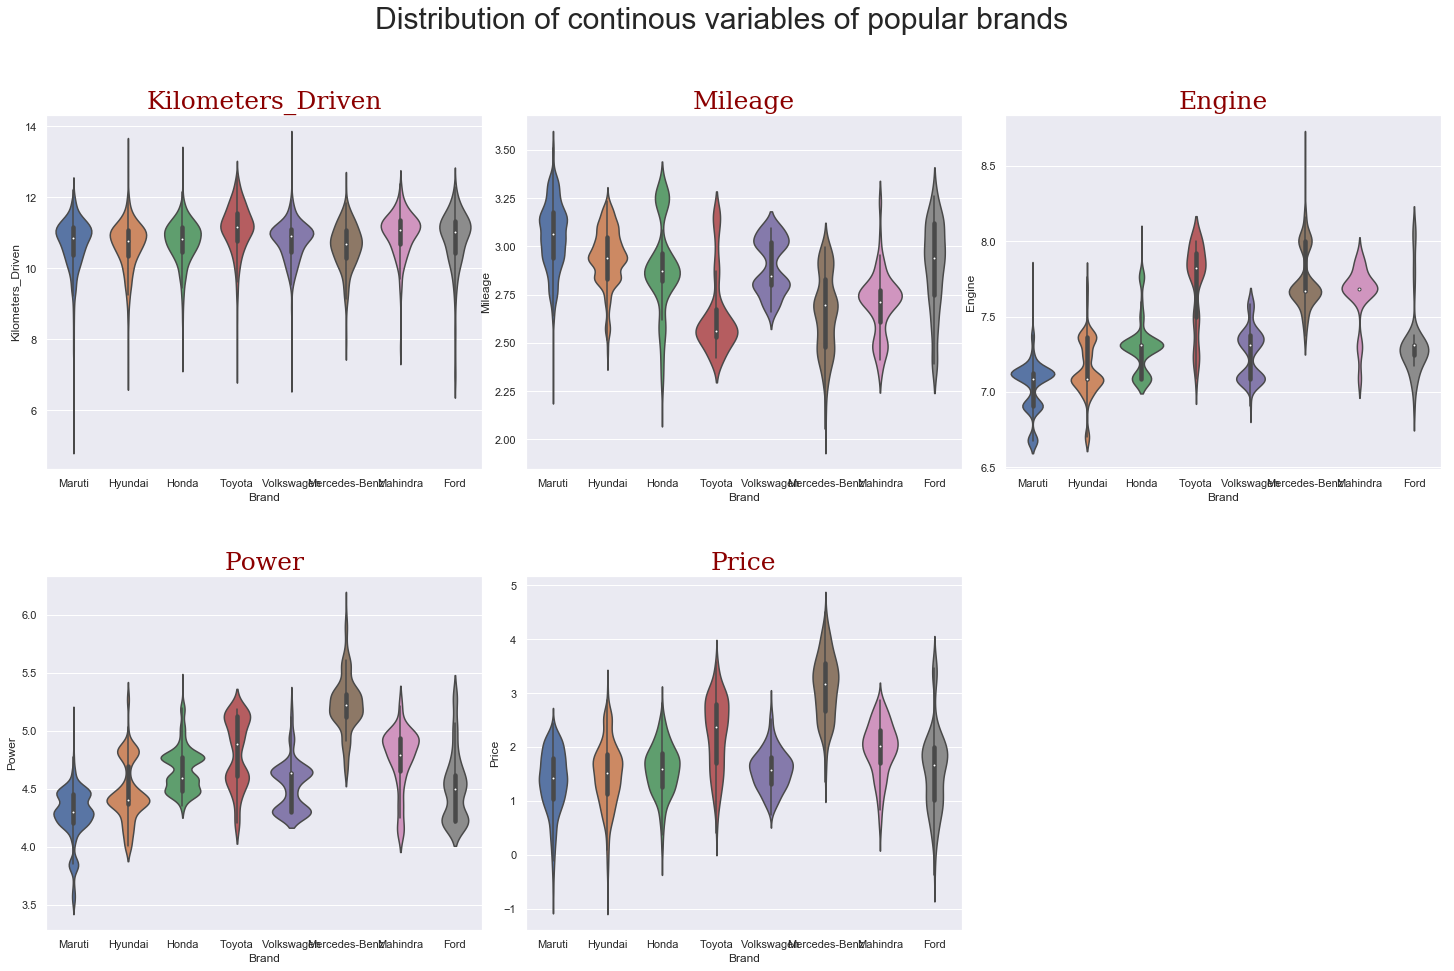

In [13]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']

inds = training_set.Brand.isin(training_set.Brand.value_counts().head(8).index)

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables of popular brands', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    s = training_set.loc[~pd.isna(training_set[col]),col].apply(np.log)
    s = s[~s.isin([-np.inf])]
    sns.violinplot(x=training_set.Brand[inds], y=s, ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)
fig.delaxes(axes[-1])

There should exist variability across the models which makes good for prediction and this variability should be consistent wih the variabilty observed with the target varaible.

- distribution Eninge capacity and power are consistent with target variable price and with each other as well. It is expected that higher the engine capacity and power higher will be the price.

- When it comes to milage It has inverse relation with the target. brand distribution shift up in the milage plot and shift lower in the price plot indication as opposed to belief that higher milage fetch higher price. It could causation effect, in general milage may not influence on the price.

The stroy is no diiferent for model case

#### Models

##### Models vs categorical

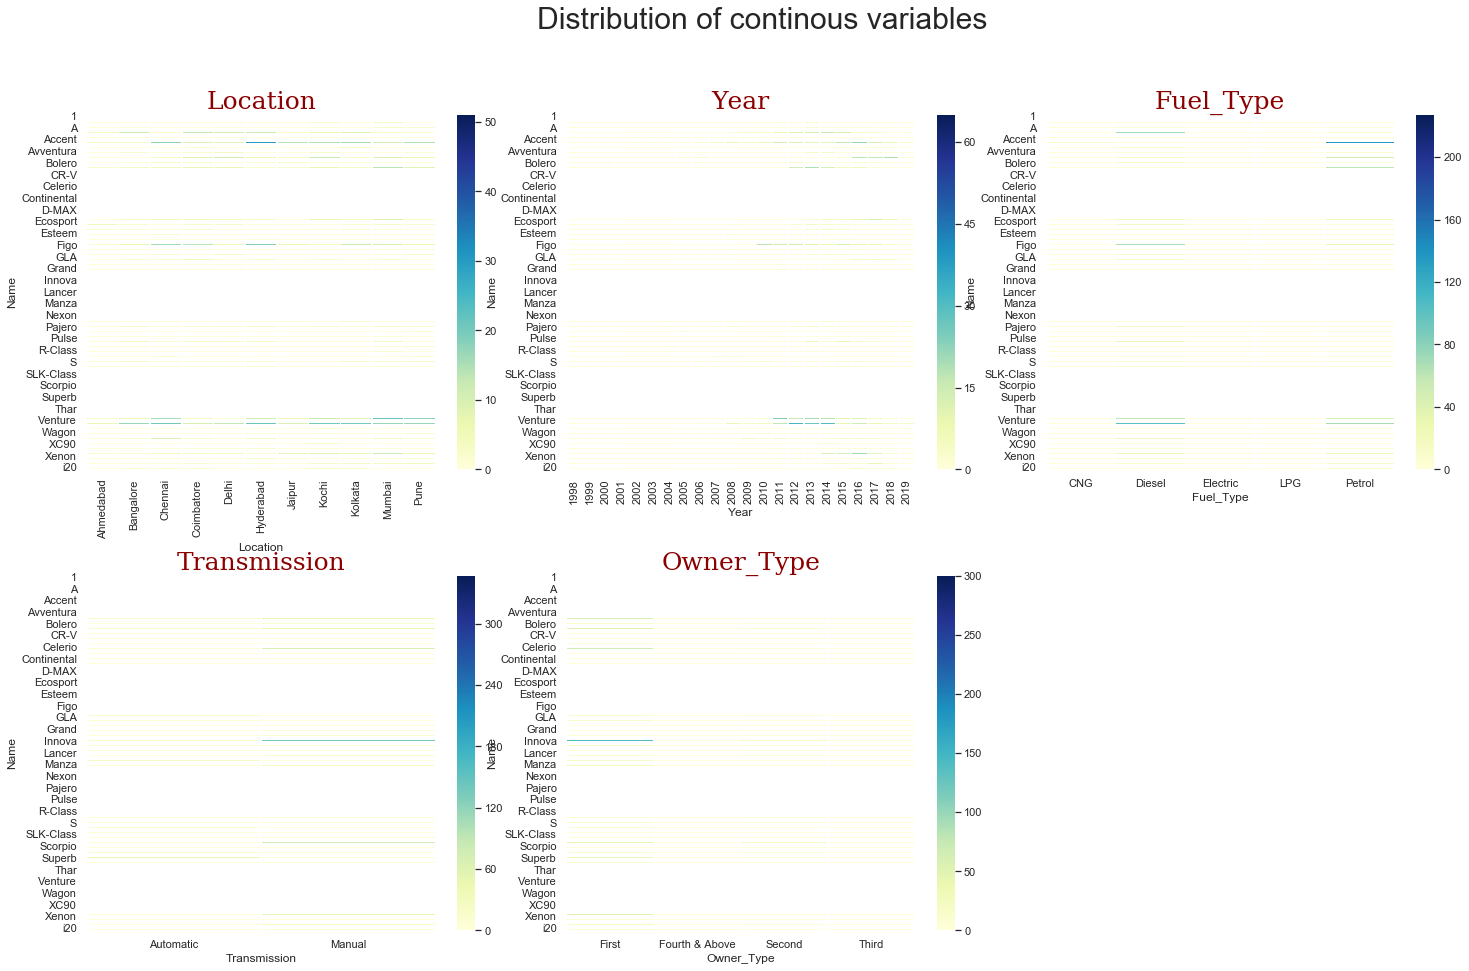

In [197]:
cols = ['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type']

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    tab = pd.crosstab(index=Models,columns=training_set[col])
    sns.heatmap(tab,linewidths=0.5,cmap="YlGnBu", ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

##### Models vs Continous

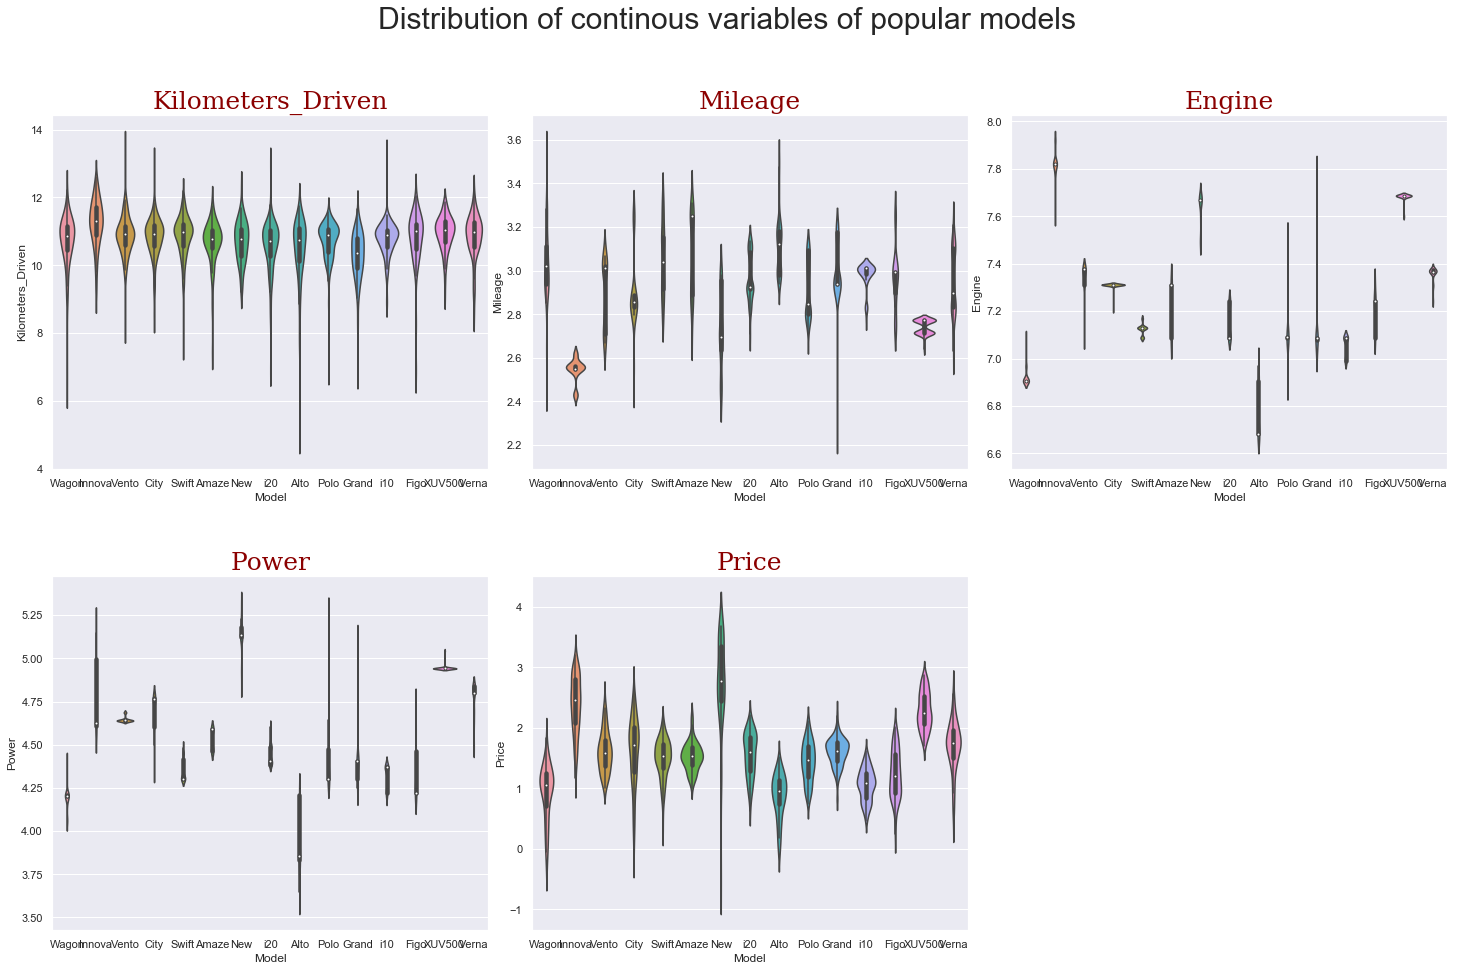

In [15]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']

# selecting top 10 Models
inds = training_set.Model.isin(training_set.Model.value_counts().head(15).index)

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables of popular models', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    s = training_set.loc[~pd.isna(training_set[col]),col].apply(np.log)
    s = s[~s.isin([-np.inf])]
    sns.violinplot(x=training_set.Model[inds], y=s, ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)
fig.delaxes(axes[-1])

### Compare prices across cities

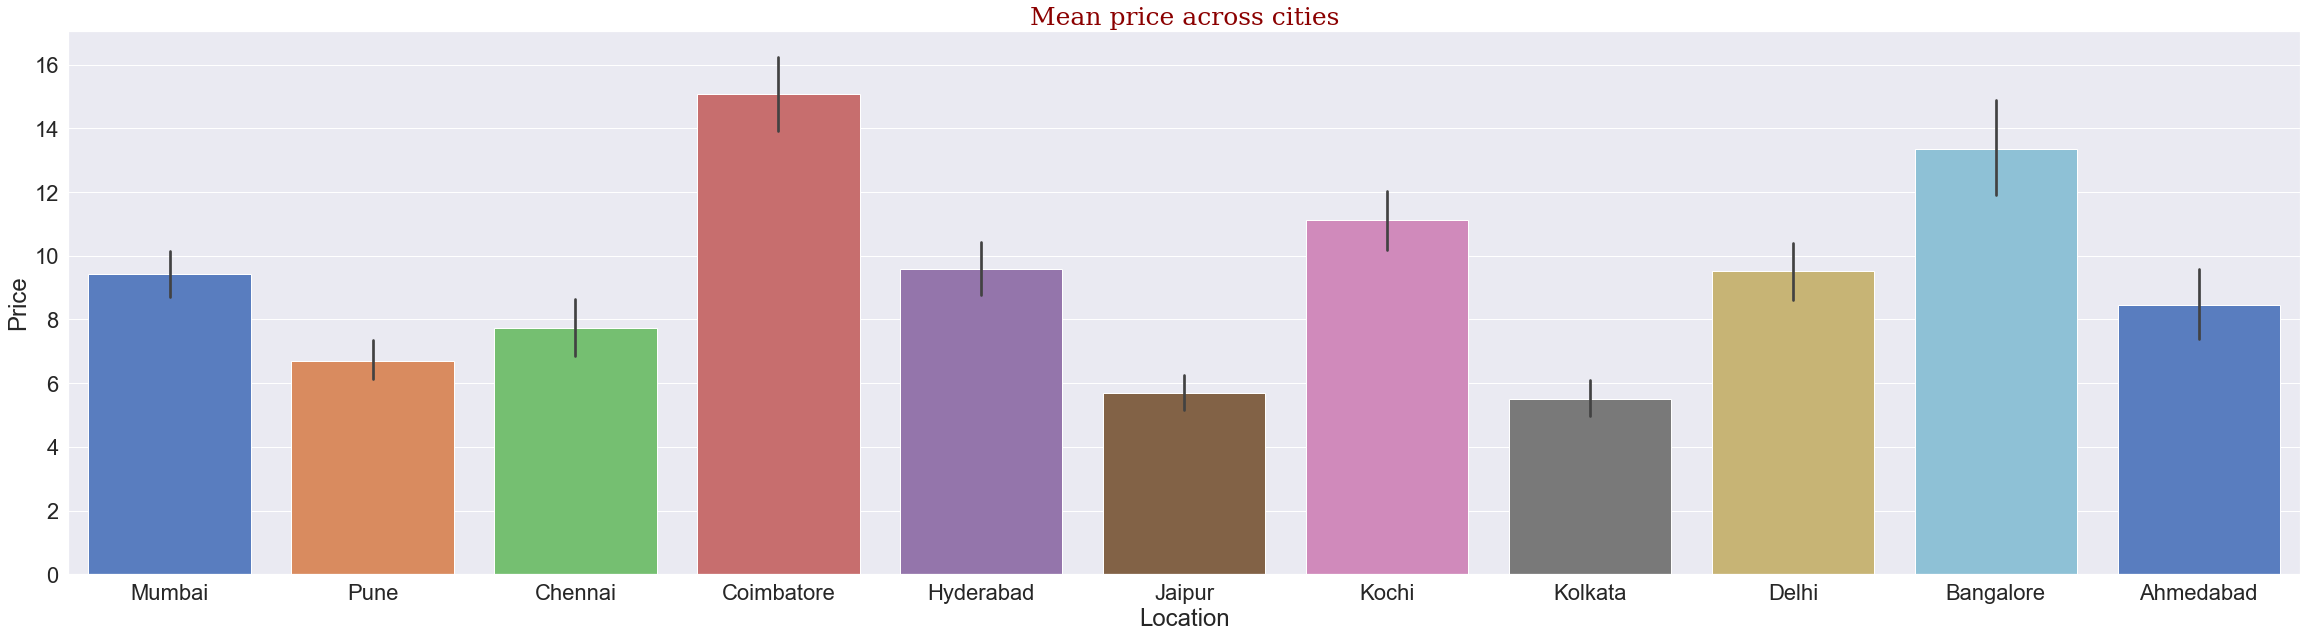

In [21]:
#sns.set(font_scale = 2)

plt.figure(figsize=(40,10))
sns.barplot(x="Location", y="Price", data=training_set,palette="muted")
plt.title("Mean price across cities",fontdict = font, fontsize=25);
#plt.xlabel('PC1',fontsize = 18);

Plot says on overall Coimatore is highest in paying for used cars, and Jaipur and Kolkata lowest. This could mean coimatore is paying comparitively higher prices or coimatore is in forefront in buying expensive cars which pushes the city to the top and vice versa for Jaipur and Kolkata.

In order to find out, let's compare the prices for individual models across the cities.

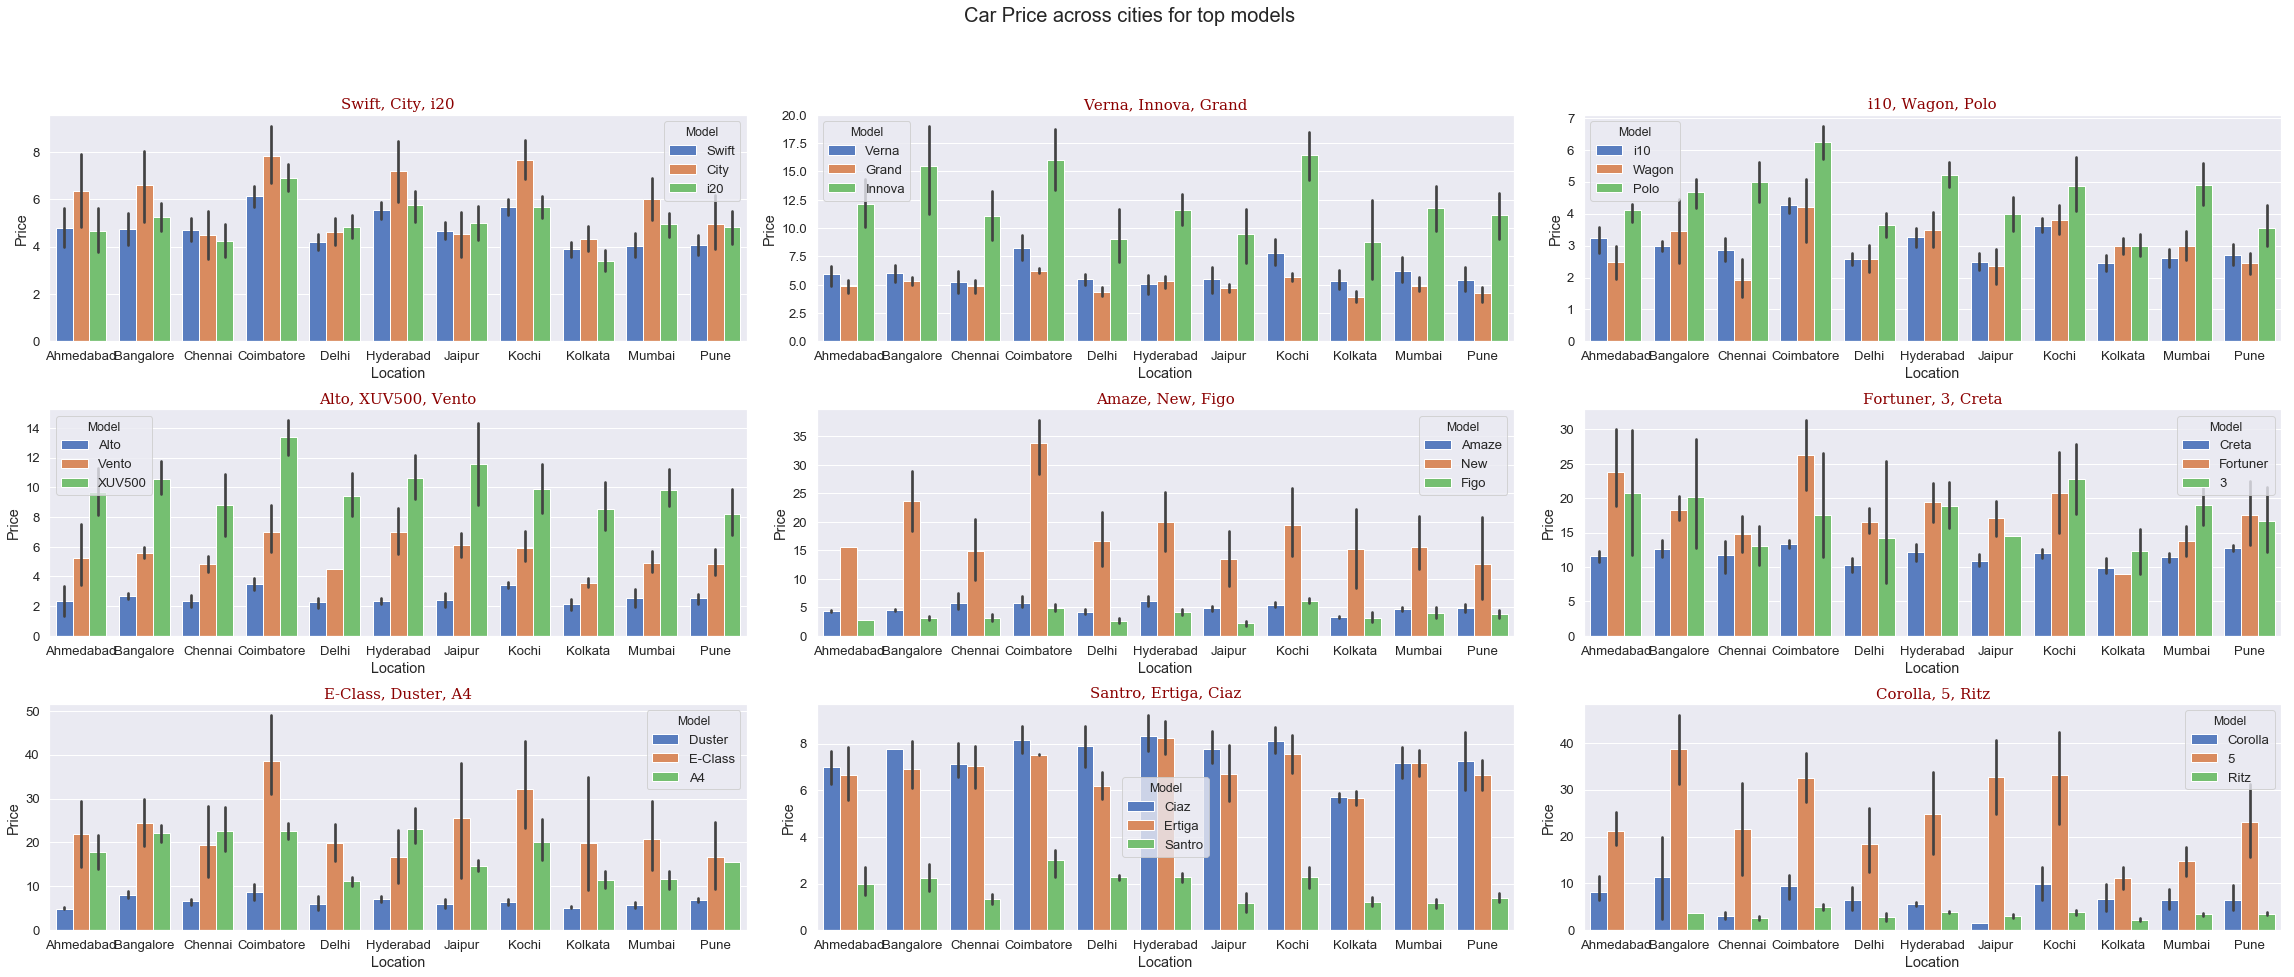

In [42]:
test_models=training_set.Model.value_counts().head(27).index
sns.set(font_scale = 1.2)

fig,axes = plt.subplots(3,3,figsize=(40,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Car Price across cities for top models', fontsize=20)
axes = axes.ravel()


for i, ind in enumerate(range(0,27,3)):
    df = training_set[training_set.Model.isin(test_models[ind:ind+3])].copy()
    df.sort_values("Location", axis = 0, ascending = True, inplace = True)
    sns.barplot(x="Location", y="Price", hue="Model", data=df,palette="muted", ax=axes[i])
    axes[i].set_title(", ".join(test_models[ind:ind+3]),fontdict = font, fontsize=15);


Similar pattern exist even within the models. That means Coimaore is indeed paying compartively higher prices than counter parts. Opposite beviour can be noticed Jaipur and Kolkata here as well.

### Compare prices across purchase year

General intuiation is that car purchased in a particular year should fetch more price than the one purchsed earlier. let create a plot similar to prevoius one but for year check whether its true or not.

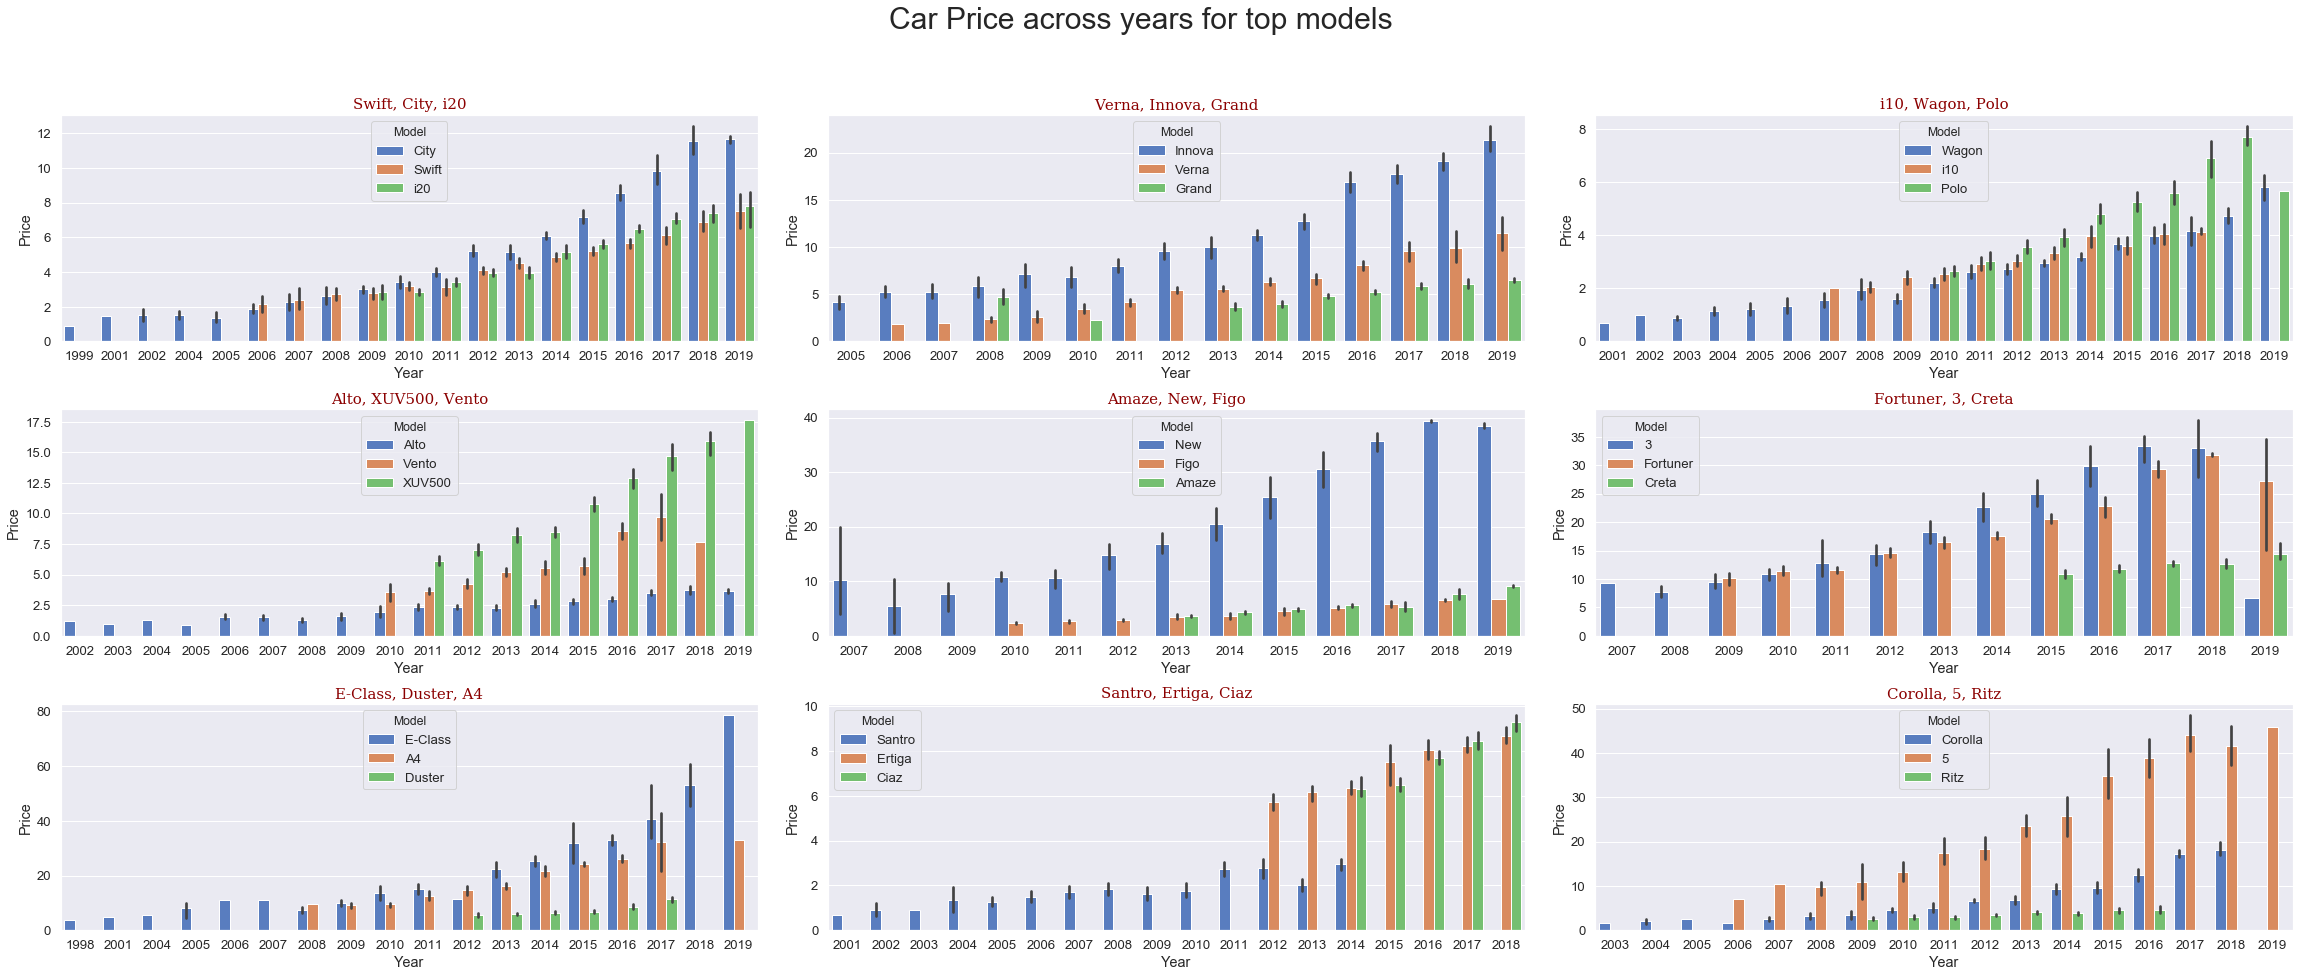

In [44]:
test_models=training_set.Model.value_counts().head(27).index
sns.set(font_scale = 1.2)


fig,axes = plt.subplots(3,3,figsize=(40,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Car Price across years for top models', fontsize=30)
axes = axes.ravel()


for i, ind in enumerate(range(0,27,3)):
    df = training_set[training_set.Model.isin(test_models[ind:ind+3])].copy()
    df.sort_values("Year", axis = 0, ascending = True, inplace = True)
    sns.barplot(x="Year", y="Price", hue="Model", data=df,palette="muted", ax=axes[i])
    axes[i].set_title(", ".join(test_models[ind:ind+3]),fontdict = font, fontsize=15)


Prices reducing as we move further away in a linear fashion which conforms our hypotheses.

### Target variablity within categorical features 

In categorical features Fuel_type and Owner_Type some categories counts are relatively low (<5%) upon one-hot encoding categorical columns increases dimensionality. Question is, is it worth it to add these columns ? to answer we could look at how much extra information these columns add.

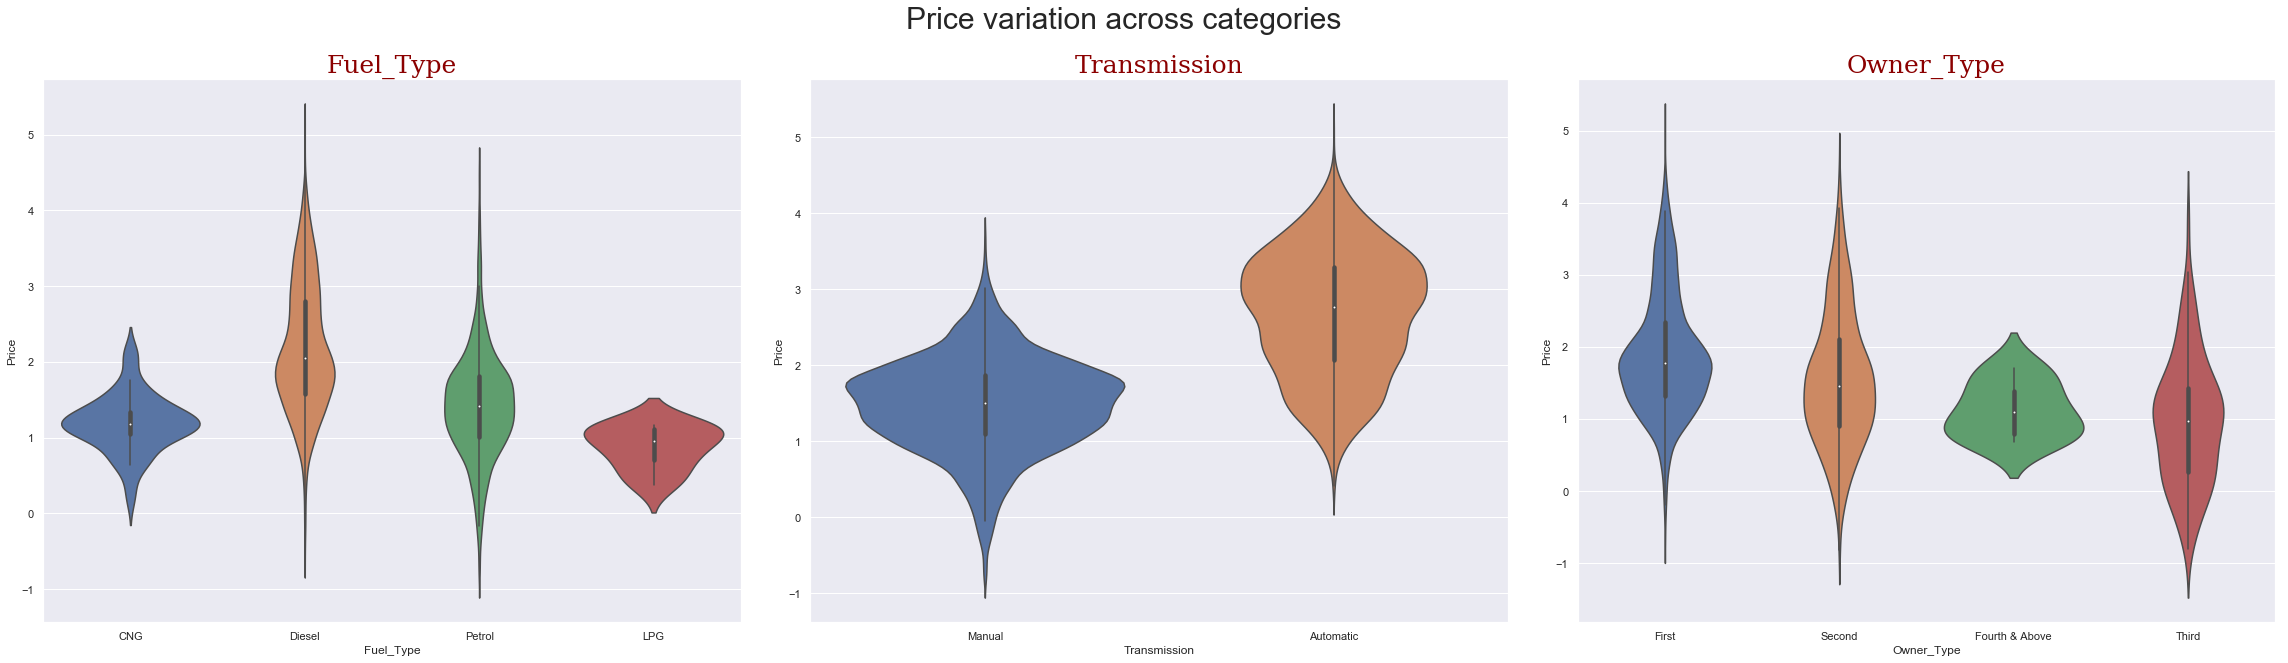

In [20]:
cols = ['Fuel_Type', 'Transmission','Owner_Type']


fig,axes = plt.subplots(1,3,figsize=(40,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Price variation across categories', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    s = training_set.loc[~pd.isna(training_set['Price']),'Price'].apply(np.log)
    s = s[~s.isin([-np.inf])]
    sns.violinplot(x=training_set[col], y=s, ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)


The minor categories CNG and LPG distributions of Fuel_type are different (mean is slightly below and std dev is much less) from the other two hence inclusion of these can add more information. These two can be combined into single category and included.

Where as minor categories Third and Fourth & Above mean values of Owner_Type do not differ much hence can be dropped. No evidence that

### Seats

5.0     5043
7.0      672
8.0      132
4.0       95
6.0       31
2.0       11
10.0       5
9.0        3
Name: Seats, dtype: int64


Text(0.5,1,'Seats')

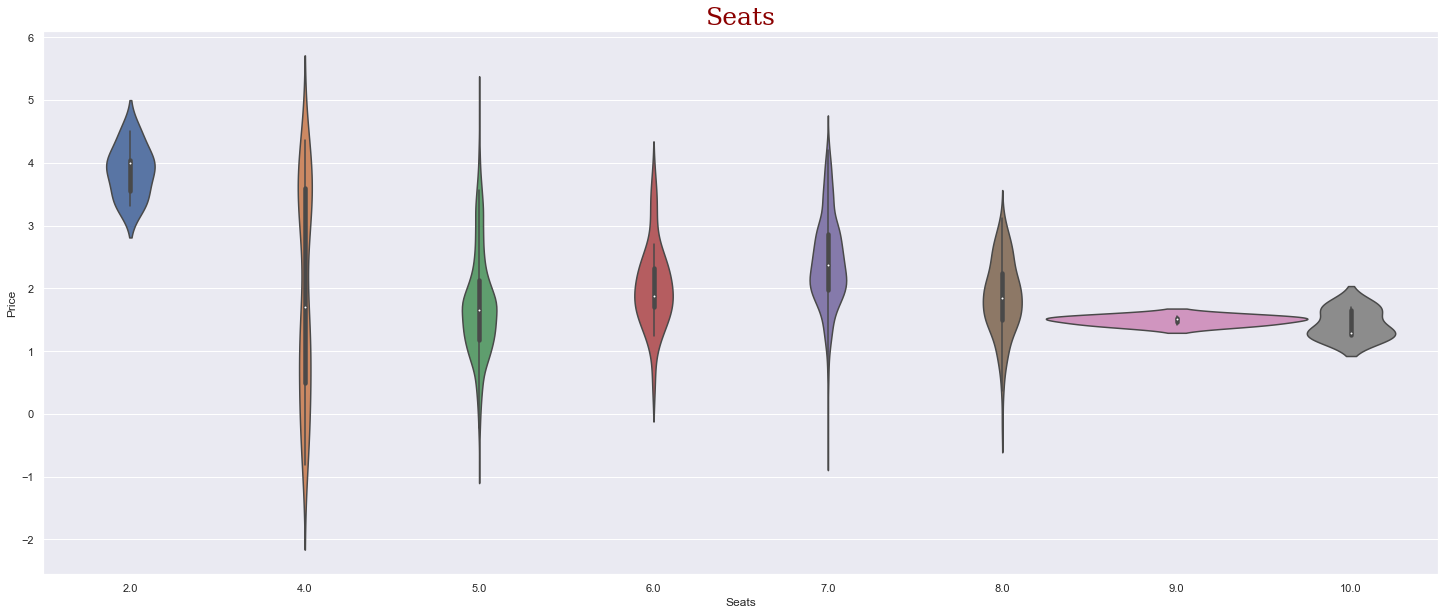

In [23]:
## #sns.set(font_scale = 2)

print(training_set.Seats.value_counts(normalize=False))

plt.figure(figsize=(25,10))

s = training_set.loc[~pd.isna(training_set['Price']),'Price'].apply(np.log)
s = s[~s.isin([-np.inf])]
sns.violinplot(x=training_set['Seats'], y=s,width=1.5)    
plt.title('Seats',fontdict = font, fontsize=25)

Interestly, mean price for 2-seater vehicle are way higher than the others. Mostly, 2 seater cars in our dataset fall under luxury category. But, given its count is comparatively low (just 11), it cannot be universally accepted.

### Features association with  dependent variable

Let's see how are continous dependent variables related with each other and with target variable.



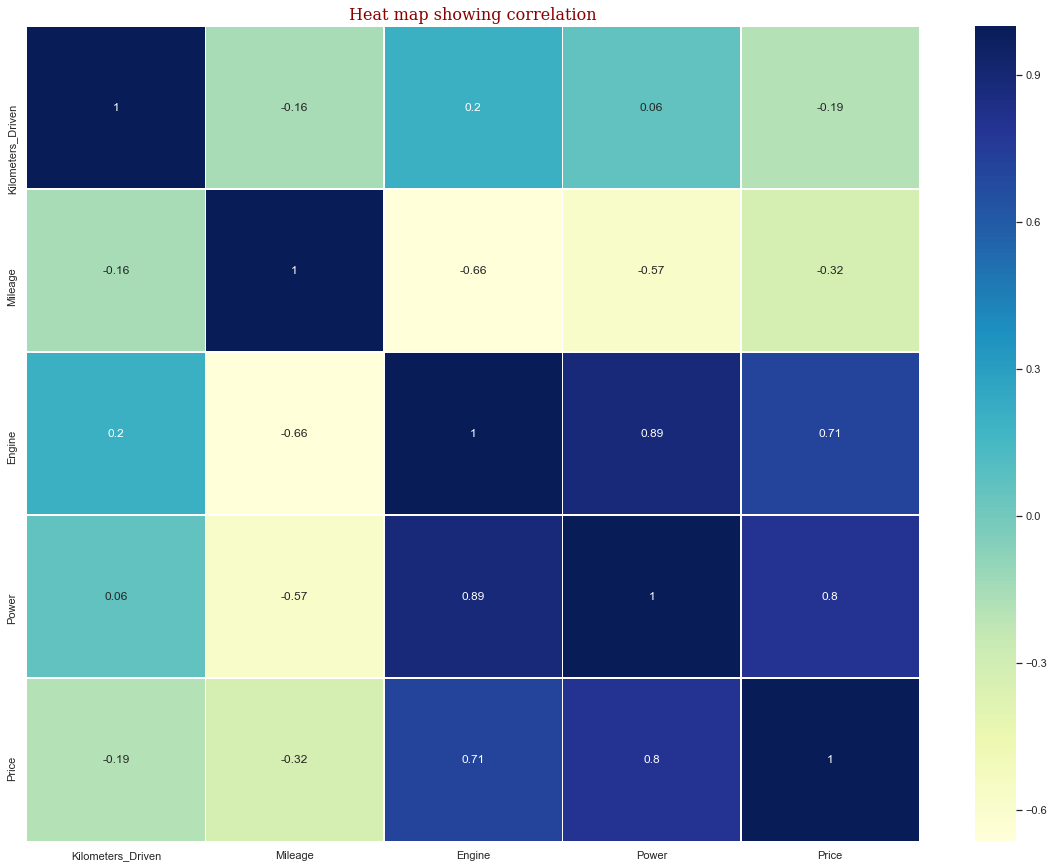

In [130]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

plt.figure(figsize=(20,15))
sns.heatmap(training_set[cols+['Price']].apply(np.log).corr(),linewidths=0.5,cmap="YlGnBu", annot=True);
plt.title("Heat map showing correlation",fontdict=font);

- surpursingly Kilometers_Driven doesn't seem to influence target variable and Mileage negatively affects price which could be result of caustion discussed earlier.

- Both Engine and Power have strong correlation with taget and Also with each other which is pretty inituitive as higher engine capacity imply higher power.

- There exists a multicolinearity between Engine capacity and power.

In [21]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  Price              6019 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 564.4+ KB


In [48]:
list(itertools.combinations(cols,2))

[('Kilometers_Driven', 'Mileage'),
 ('Kilometers_Driven', 'Engine'),
 ('Mileage', 'Engine')]

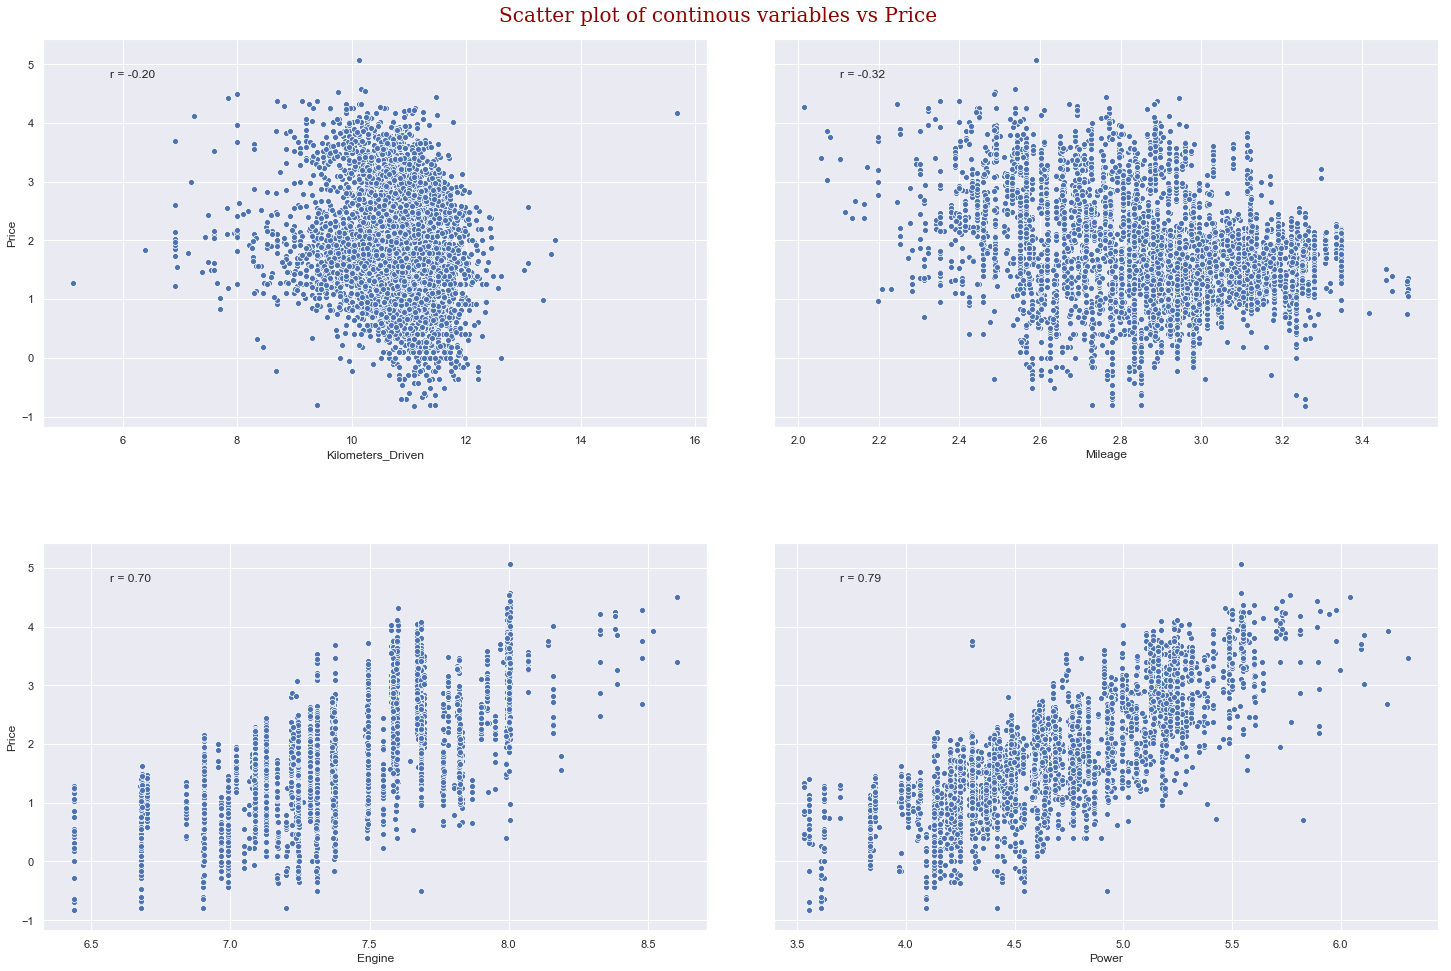

In [17]:


cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Scatter plot of continous variables vs Price',fontsize = 20, fontdict=font)
fig.subplots_adjust(top=0.95)

axes = axes.ravel()

for i,col in enumerate(cols):
    inds = ~pd.isna(training_set[col])
    #-----with log transformation
    x = training_set[col][inds].apply(np.log)
    y = training_set['Price'][inds].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i])
    
    #----normal
    #sns.scatterplot(training_set[col],training_set['Price'],ax=axes[i])
    
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)

- Engine volume and Power has a strong association with the price.

- Where as Price is not impacted much by Kilometer_driven and Mileage.

In [56]:
list(itertools.combinations(cols,2))

[('Kilometers_Driven', 'Mileage'),
 ('Kilometers_Driven', 'Engine'),
 ('Mileage', 'Engine')]

#### Interaction between variables

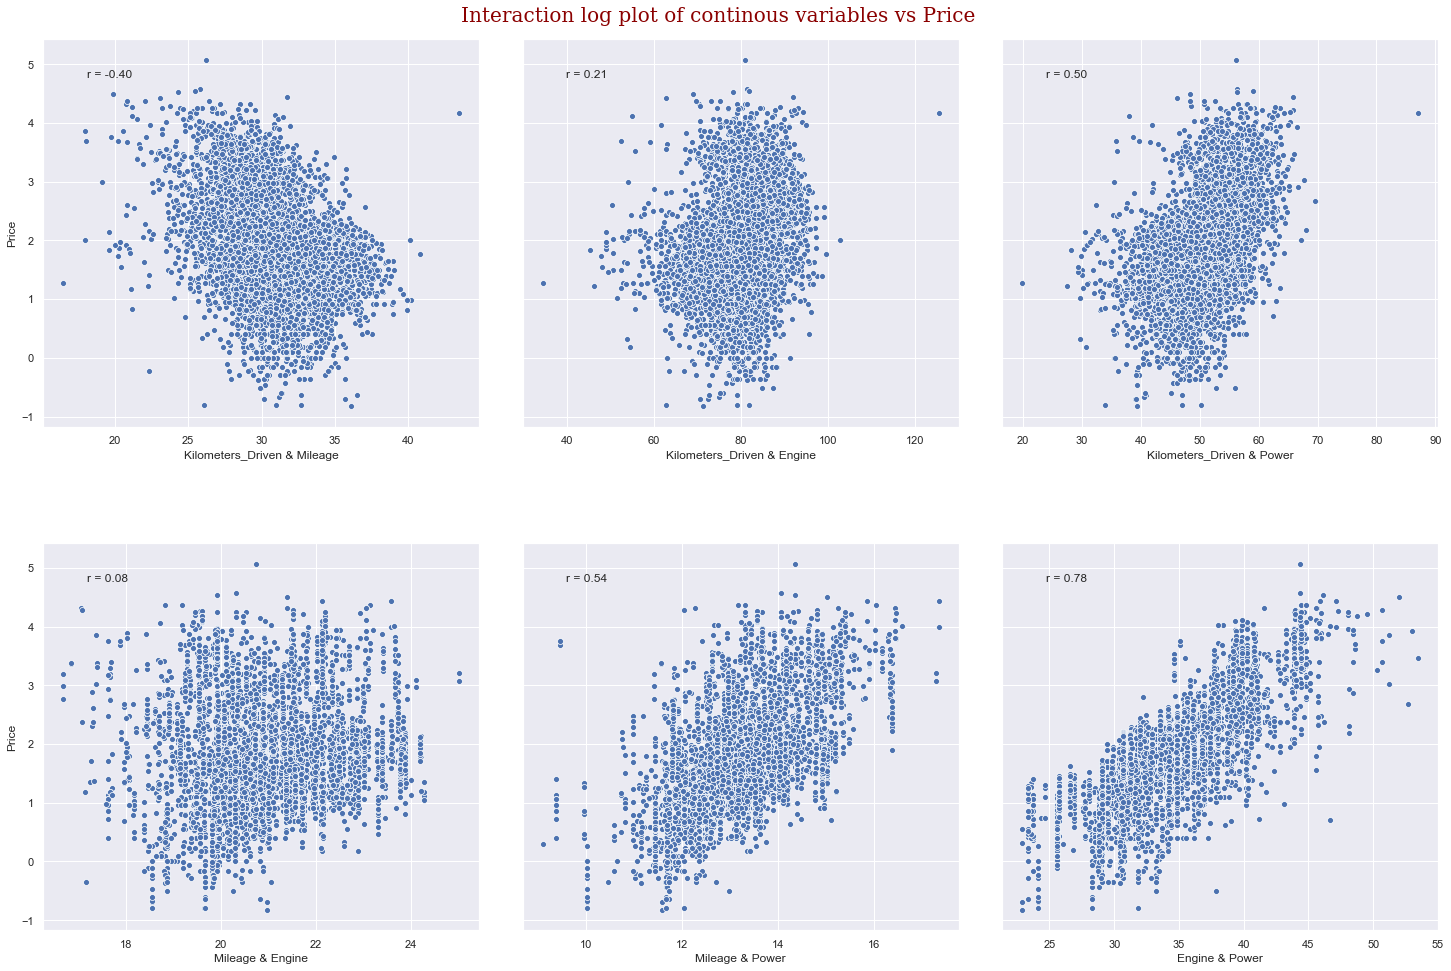

In [16]:
#               *******   Interaction between Milege and Kilometer Driven **********
cols = ['Kilometers_Driven', 'Mileage', 'Engine','Power']

fig,axes = plt.subplots(2,3,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Interaction log plot of continous variables vs Price', fontsize= 20, fontdict=font)
fig.subplots_adjust(top=0.95)

axes = axes.ravel()

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

for i, tup in enumerate(itertools.combinations(cols,2)):
    col1 = tup[0]
    col2 = tup[1]
    inds = ~(pd.isna(training_set[col1]) | pd.isna(training_set[col2]))
    x= training_set[col1][inds].apply(np.log)*training_set[col2][inds].apply(np.log)
    y = training_set['Price'][inds].apply(np.log)
    sns.scatterplot(x,y,ax=axes[i]);
    axes[i].set_xlabel(f'{col1} & {col2}')
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)


- Even Engine volume and Power combined has a strong positive association with the price which is obvious.

- Rest other doesn't seem to have impact on the price.

- Interestingly, features milage and Kilometer_driven which do not have effect on the price individaul shows a signinificant negative correlation in combination.

### Testing Multicollineaity

Linear regression models get adresly effected in the presence of multicollinear features. If model primary purpose is interpretability then having multicollinear features make model (co effiecients) less reliable and sometimes even misleading.



#### VIF test for Multi-colinearity

VIF is the widely used test for checking multicollinearity in the data. VIF measures dependence of features with others by fitting regression line. basically it tries to quantify amt of change in target response with change in linear combination of other variables. It uses R-square metric to compute VIF (1 / (1 - R-square)). VIF < 5 (R-square = 0.8) is aceptable more than that indicate colinearity.

In [26]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5992 non-null   float64
 10  Power              5992 non-null   float64
 11  Seats              5992 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 608.7+ KB


In [29]:
training_set = pd.read_csv('DataSets/TrainSet_Cleaned.csv')

cols = ['Power','Engine','Kilometers_Driven','Mileage','Seats']


vif_scores = dict()

tmp = training_set[cols].copy()
tmp = tmp.apply(np.log)

for i in cols:
    y = tmp[i]
    x = tmp.drop(i,axis=1)
    x = sm.add_constant(x)
    model = sm.OLS(y, x.astype(float))
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "R Square value of {} column is {} keeping all other columns as features".format(
            i, (round(rsq, 2))
        )
    )
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            i, vif)
        )
    vif_scores[i] = vif

R Square value of Power column is 0.83 keeping all other columns as features
Variance Inflation Factor of Power column is 5.82 

R Square value of Engine column is 0.87 keeping all other columns as features
Variance Inflation Factor of Engine column is 7.44 

R Square value of Kilometers_Driven column is 0.09 keeping all other columns as features
Variance Inflation Factor of Kilometers_Driven column is 1.1 

R Square value of Mileage column is 0.46 keeping all other columns as features
Variance Inflation Factor of Mileage column is 1.85 

R Square value of Seats column is 0.32 keeping all other columns as features
Variance Inflation Factor of Seats column is 1.47 



seems like Engine and Power exibits high multicolineaity i.e strong association with the rest of the features.



#### Anova for feature dependenace 

t-test is for comparing mean of two samples (two categories in a feature) While Anova compares means of multiples samples (more than two categories). when only two categories in a feature either of them can be used.

Idea here is that, in order to tell a categorical feature associated with the target there should be variation in target distribution across the categories i.e target distribution correponding to each of the category.

Assumtions:

- Obersevations are IIDs (independent identical distributed)

- samples follow normal distribution.

- both samples must have equal variance (homogenity)

In [30]:
cols = training_set.select_dtypes('object').columns.tolist()

# t-test and anova assumes data to normally distributed

tmp = training_set[cols].copy()

y = training_set.Price.apply(np.log)

for col in cols:
    cat_y = []
    for cat in tmp[col].unique():
        cat_y.append(y[tmp[col]==cat])
    print(f'{col}:\n{f_oneway(*cat_y)}')
    

Brand:
F_onewayResult(statistic=294.9573908330804, pvalue=0.0)
Model:
F_onewayResult(statistic=122.4073799480774, pvalue=0.0)
Location:
F_onewayResult(statistic=74.05390489637388, pvalue=1.24184135441653e-143)
Fuel_Type:
F_onewayResult(statistic=481.29653853627354, pvalue=3.513024865550255e-280)
Transmission:
F_onewayResult(statistic=3660.5079482274805, pvalue=0.0)
Owner_Type:
F_onewayResult(statistic=84.16775431316191, pvalue=2.4548585135147553e-53)


## Feature Enginnering

Clean the columns by removing white spaces and split Name feature into Brand and Model. 

In [35]:
training_set.head()

Name    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010              72000   
1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015              41000   
2                      Honda Jazz V     Chennai  2011              46000   
3                 Maruti Ertiga VDI     Chennai  2012              87000   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013              40670   

  Fuel_Type Transmission Owner_Type  Mileage  Engine   Power  Seats  Price  
0       CNG       Manual      First    26.60   998.0   58.16    5.0   1.75  
1    Diesel       Manual      First    19.67  1582.0  126.20    5.0  12.50  
2    Petrol       Manual      First    18.20  1199.0   88.70    5.0   4.50  
3    Diesel       Manual      First    20.77  1248.0   88.76    7.0   6.00  
4    Diesel    Automatic     Second    15.20  1968.0  140.80    5.0  17.74

### Creating Brand and Model feature

In [36]:
# Data Cleaning and Feature  

# Split Car name feature into Brand and Model features for both sets 
training_set['Brand'] = [i.split(' ')[0].strip() for i in training_set.Name]
training_set['Model'] = [i.split(' ')[1].strip() for i in training_set.Name]
training_set.drop(labels=['Name'],axis=1,inplace=True)

test_set['Brand'] = [i.split(' ')[0].strip() for i in test_set.Name]
test_set['Model'] = [i.split(' ')[1].strip() for i in test_set.Name]
test_set.drop(labels=['Name'],axis=1,inplace=True)

# REordering Cols

order_cols = ['Brand', 'Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
  'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']
training_set = training_set[order_cols]

# if any model has single count will drop 
drop_models = training_set.Model.value_counts()[training_set.Model.value_counts()==1].index
training_set = training_set[~training_set.Model.isin(drop_models)]

### Handling Missing values

There are some missing values in the ['Mileage', 'Engine', 'Power', 'Seats'] columns. First three continous varaibles are imputed with mean and Mode for last variable of corresponding models

#### Filling values

In [37]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5956 non-null   float64
 10  Power              5853 non-null   float64
 11  Seats              5950 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 815.4+ KB


Firstly, New_Price feature has 824 values filled out of 6019. This feature could have been important one as customer takes into market price before deciding whether used car quoted price is resonable or not. Since we don't have much information on this dropping the feature is acceptable.

There are some values missing in Mileage, Engine, Power, Seats too though not significant. First three continous varaibles are imputed with mean and mode for last variable which is categorical. Instead of imputing with coulmn satistic we could impute with group mean of the model category missing example belongs to, seems more appropriate. let plot to see whether group feature distribution is significatly different across various categories.

In [40]:
training_set.Power.head(),training_set.Power.loc[[4,1]]

(0     58.16
 1    126.20
 2     88.70
 3     88.76
 4    140.80
 Name: Power, dtype: float64,
 4    140.8
 1    126.2
 Name: Power, dtype: float64)

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

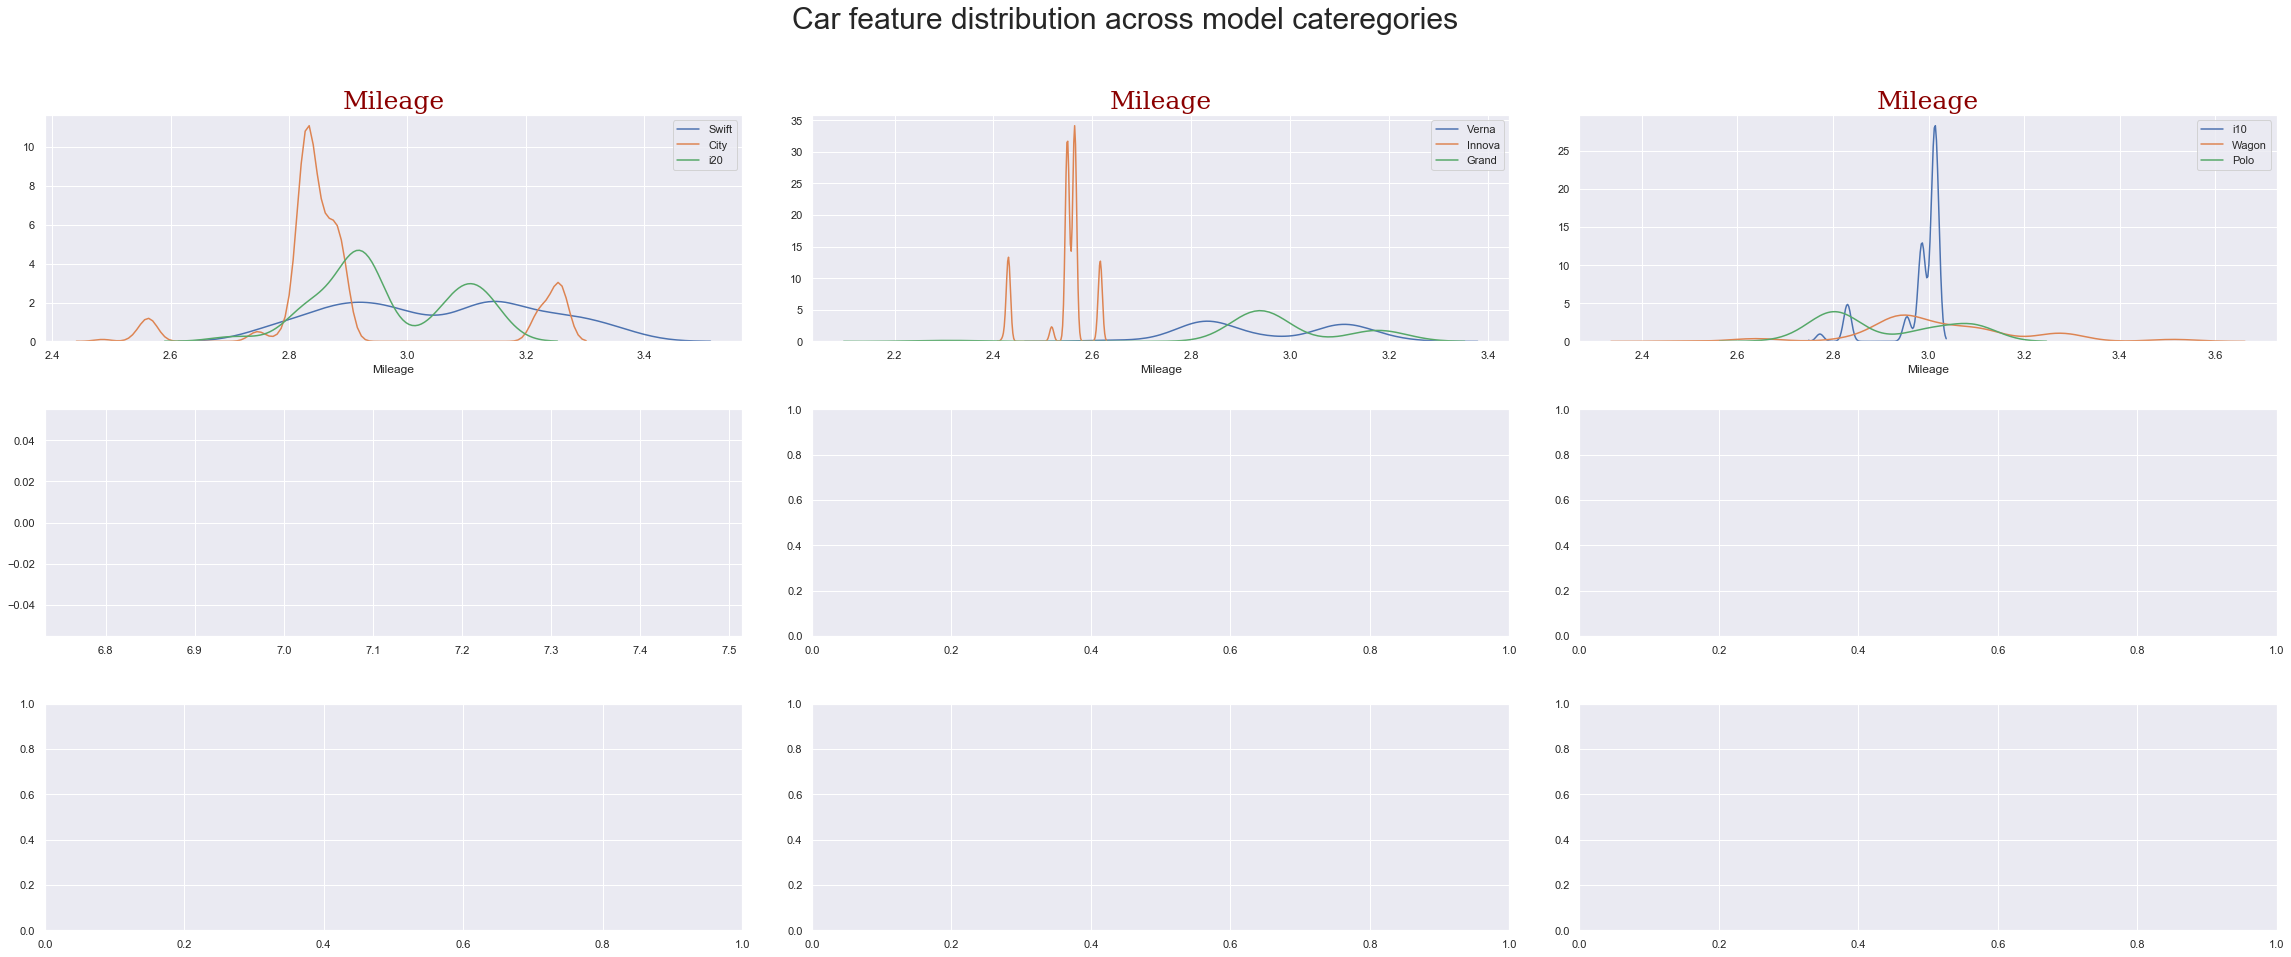

In [36]:
missing_cols = ['Mileage', 'Engine', 'Power']

# plot distributions for various models
test_models=training_set.Model.value_counts().head(27).index


fig,axes = plt.subplots(3,3,figsize=(40,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Car feature distribution across model cateregories', fontsize=30)
axes = axes.ravel()

i=0
for col in missing_cols:
    for ind in range(0,9,3):
        df = training_set[training_set.Model.isin(test_models[ind:ind+3])].copy()
        for j in test_models[ind:ind+3]:
            sns.distplot((df.loc[df.Model == j,col][~pd.isna(df[col])]).apply(np.log), hist= False,ax=axes[i], label = j)
        axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
        i+=1

Plot of feature distribution across model categories. Note range vary across model and even within model there has significance varience with sharp peaks indicating high frequency. I am filling the missing cells with this most likely value of group filtered by model category.

#### Filling with mode

In [64]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5992 non-null   float64
 10  Power              5992 non-null   float64
 11  Seats              5992 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 655.4+ KB


In [ ]:
missing_cols = ['Mileage', 'Engine', 'Power', 'Seats']
training_set.replace({0:np.nan},inplace=True)
for col in missing_cols:
    missing_inds = training_set[col].isna()
    missing_mods = set(training_set.Model[missing_inds])
    for i,mod in enumerate(missing_mods):
        s = training_set.loc[training_set.Model==mod, col]
        if len(s.mode())>0:
            training_set.loc[((training_set.Model==mod) & (missing_inds)), col] = training_set.loc[((training_set.Model==mod) & (missing_inds)), col].fillna(s.mode().iloc[0])
    training_set.loc[(training_set[col].isna()), col] = training_set.loc[(training_set[col].isna()), col].fillna(training_set[col].mode().iloc[0])

In [65]:
training_set.to_csv('DataSets/TrainSet_Cleaned.csv',index=False,header=True)

### Read Clean Data without missing 

In [3]:
training_set = pd.read_csv('DataSets/TrainSet_Cleaned.csv')

In [4]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5992 non-null   float64
 10  Power              5992 non-null   float64
 11  Seats              5992 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 608.7+ KB


### Train and Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(training_set.iloc[:,:-1],training_set['Price'].values, 
                                                    test_size = 0.2,stratify = training_set.Model, shuffle = True,random_state = 0)

NameError: name 'sns' is not defined

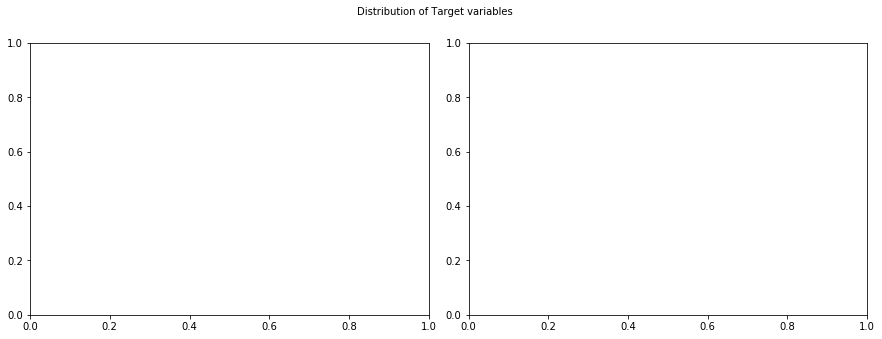

In [21]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of Target variables', fontsize=10)
axes = axes.ravel()

for i,col in enumerate([y_train, y_test]):
    sns.distplot(np.log(col), hist= False,ax=axes[i])
    axes[i].set_title(['Train', 'Test'][i],fontdict = font, fontsize=12)    #axes[i].set_title(col,fontsize=25)


## Model Building PipeLines

Pipeline stores all the hyperparmeters across various processing stages making it productionalize. Sklearn's pipeline is useful in streamlining all the steps involved in the model building right from cleaning and preprocessing to till model selection. pipeline is allows easy experimenting with various options. Pipeline objects can be shared and exported for deployment.

the components of pipeline that helps in streamlining processes are called Custom transformers. Custom transformers is built to apply reqiured transformation on to data by using TransformerMixin and BaseEstimator base classes. Inheriting from TransformerMixin ensures that all we need to do is write our fit and transform methods and we get fit_transform for free. Inheriting from BaseEstimator ensures we get get_params and set_params for free. These tranformers forms components of model pipeline.



### Metric Define

In [5]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as score

rmsle_score = make_scorer(score, greater_is_better=True)


### columns segregation

In [6]:
# columns segregation
Tar_cols = ['Brand', 'Model', 'Location']
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power']
One_hot_cols = ['Fuel_Type', 'Transmission', 'Owner_Type']
Year = ["Year"]
Seats = ["Seats"]

### Simple Linear Regression

#### Regresion Analysis

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     5065.
Date:                Fri, 29 May 2020   Prob (F-statistic):               0.00
Time:                        19:11:38   Log-Likelihood:                 314.47
No. Observations:                4793   AIC:                            -600.9
Df Residuals:                    4779   BIC:                            -510.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

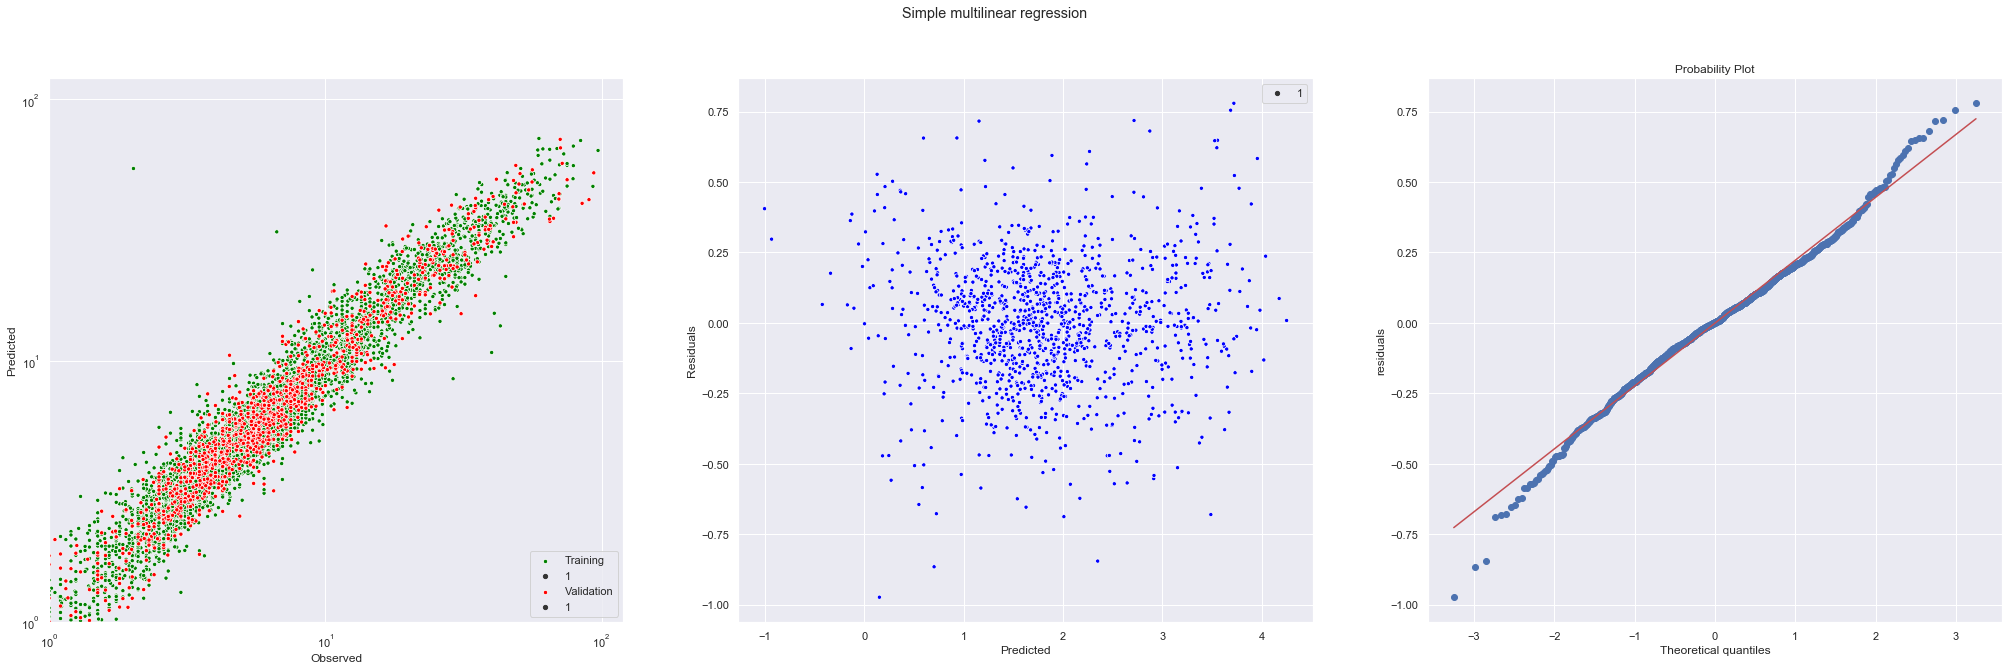

In [9]:
train_x = TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))
test_x = TransformPipeline_lin.transform(X_test)


mod = LinearRegression()
mod.fit(train_x,np.log(y_train))

train_pred_y = np.exp(mod.predict(train_x))
test_pred_y = np.exp(mod.predict(test_x))


#---- Generating Model summary results using OLS from statsmodel
X_ols = sm.add_constant(train_x)
ols = sm.OLS(np.log(y_train), X_ols)
results = ols.fit()
print(results.summary())


- Looking at Residual plot, It can be infered Data is exibiting heteroscadasticity hence linear is not appropriate. Take a look at some non linear models. perhabs my data has high varaibilty at higher levels.

- Looking at features that are Tree based algorithms are best suited for this process as most of the varibles are discrete in nature (including Power and Engine).

- Kind of the dataset, simple regression may not be best model.

#### Simple Linear regression model

In [52]:

pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
            
        ])),
    ('poly_transform',DF_PolynomialFeatures()),
    ('scale', DFStandardScaler()),
    ('feature_selection',DFRecursiveFeatureSelector(LinearRegression())),
    ('Model_fit',LinearRegression())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [63]:
pipe_params= {'feature_selection__n_features':[10,15,20,25],
              'poly_transform__degree':[1,2]}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = rmsle_score,
                        n_jobs = 10,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:    9.0s finished




 Linear Regression R-Squared: Training = 0.837, Validation = 0.81

 Linear Regression SCORE: Training = 0.811, Validation = 0.814


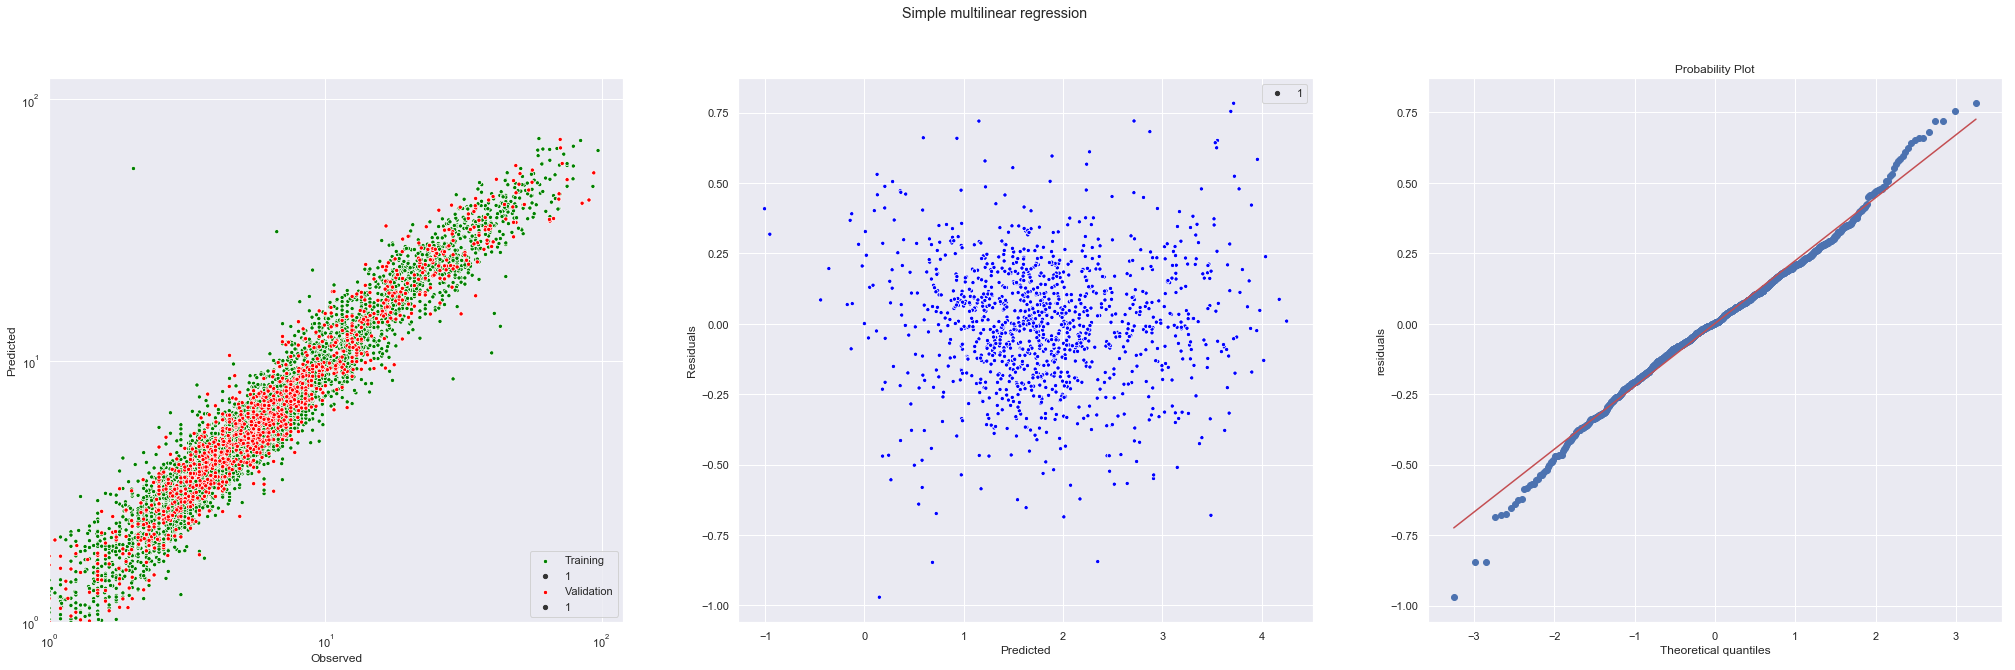

In [64]:
train_pred_y = np.exp(model.predict(X_train))
test_pred_y = np.exp(model.predict(X_test))


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)



#--- Printing the score for validation sets

print(f"\n\n Linear Regression R-Squared: Training = {round(r2_score(train_pred_y, y_train),3)}, Validation = {round(r2_score(test_pred_y, y_test),3)}")
print(f"\n Linear Regression SCORE: Training = {round(score(y_train,train_pred_y),3)}, Validation = {round(score(test_pred_y, y_test),3)}")




#          *********** Plot validation and Residuals  ********
plt.figure(figsize= (35,10))
plt.suptitle('Simple multilinear regression')
ax1 = plt.subplot(131)
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(y_train,train_pred_y,size=1, color = 'green',label = 'Training',ax=ax1);
sns.scatterplot(y_test,test_pred_y,size=1,color = 'red', label = 'Validation',ax=ax1);
plt.axis([1,120,1,120]);
plt.xlabel('Observed');
plt.ylabel('Predicted');
plt.legend(loc = 4);


ax2 = plt.subplot(132)
sns.scatterplot(np.log(test_pred_y),(np.log(y_test)-np.log(test_pred_y)) ,size=1, color = 'blue',ax=ax2)
plt.xlabel('Predicted');
plt.ylabel('Residuals');

ax3 = plt.subplot(133)
stats.probplot((np.log(y_test)-np.log(test_pred_y)), plot=ax3)
plt.ylabel('residuals');



In [65]:
model.best_params_,model.best_score_

({'feature_selection__n_features': 20, 'poly_transform__degree': 1},
 0.8830872134465901)

#### Lasso Regression

In [34]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
            
        ])),
    ('poly_transform',DF_PolynomialFeatures()),
    ('scale', DFStandardScaler()),
    ('Model_fit',Lasso())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [35]:
pipe_params= {'poly_transform__degree':[1,2],
              'Model_fit__alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10]}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    7.5s finished




 Lasso Regression R-Squared: Training = 0.94, Validation = 0.939

 Linear Regression SCORE: Training = 0.957, Validation = 0.958


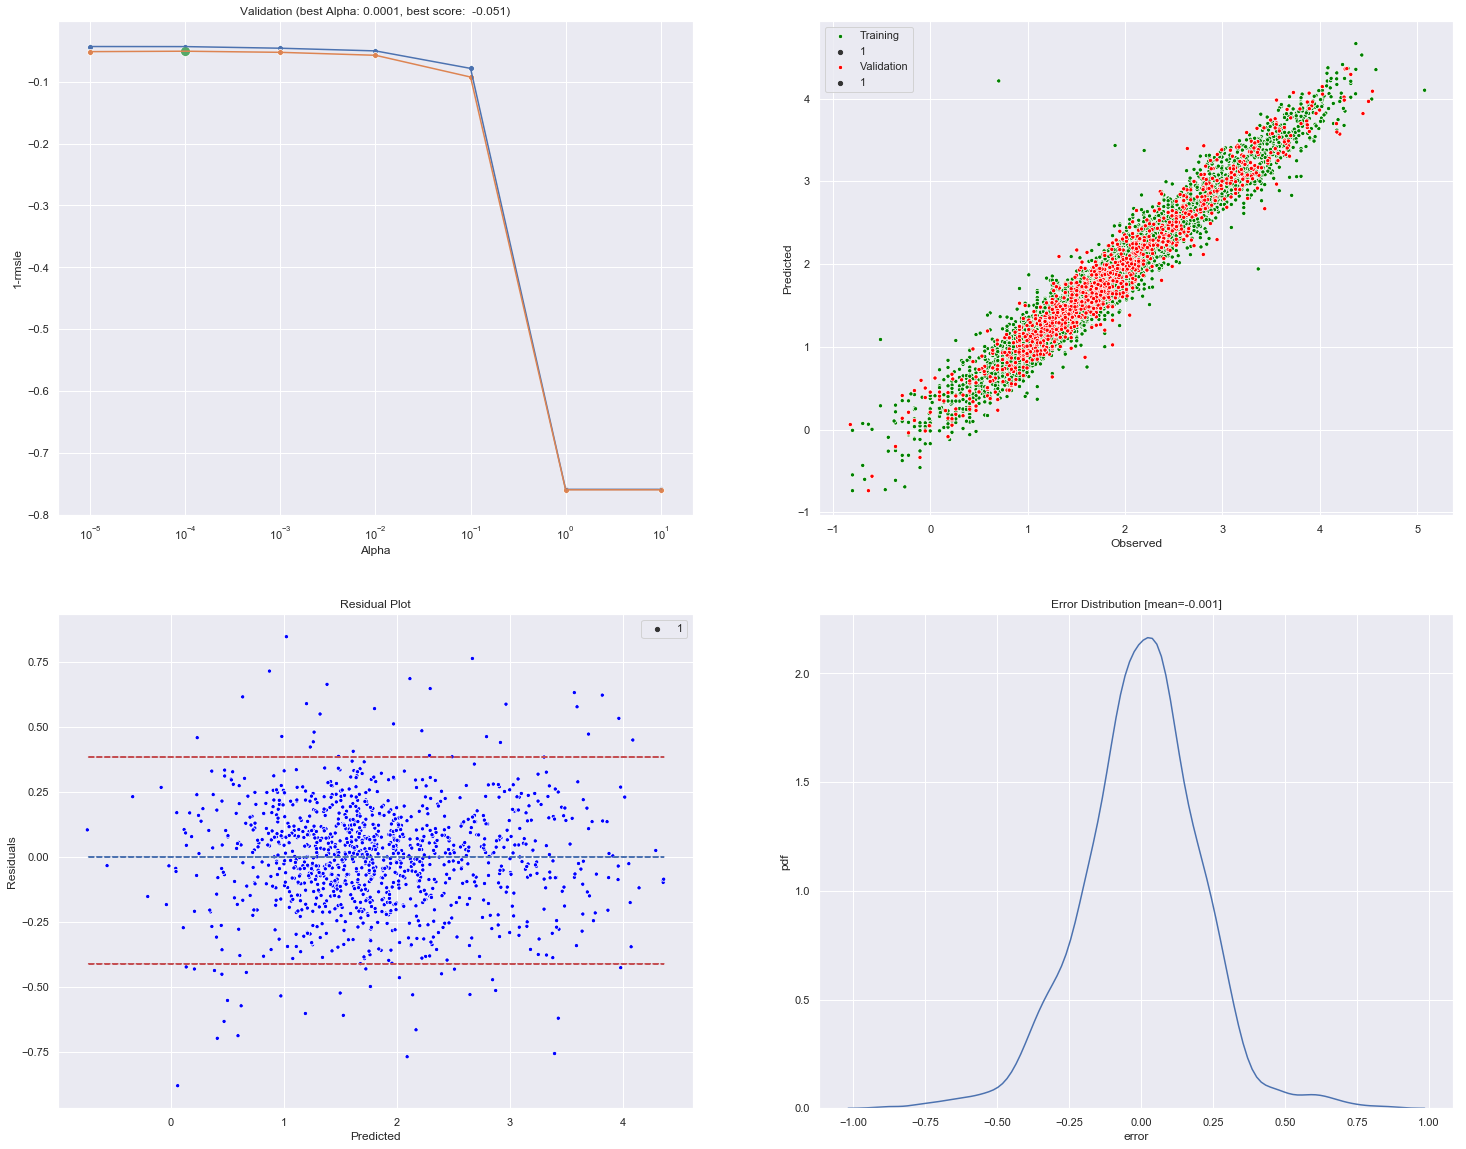

In [38]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__alpha')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best Alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [37]:
model.best_params_,model.best_score_

({'Model_fit__alpha': 0.0001, 'poly_transform__degree': 2},
 -0.0506547031441605)

#### Ridge Regression (l2)

In [39]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
            
        ])),
    ('poly_transform',DF_PolynomialFeatures()),
    ('scale', DFStandardScaler()),
    ('Model_fit',Ridge())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [40]:
pipe_params= {'poly_transform__degree':[1,2],
              'Model_fit__alpha':[0.01,0.1,0.5,1,2,5,10]}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    7.3s finished




 Lasso Regression R-Squared: Training = 0.94, Validation = 0.941

 Linear Regression SCORE: Training = 0.957, Validation = 0.958


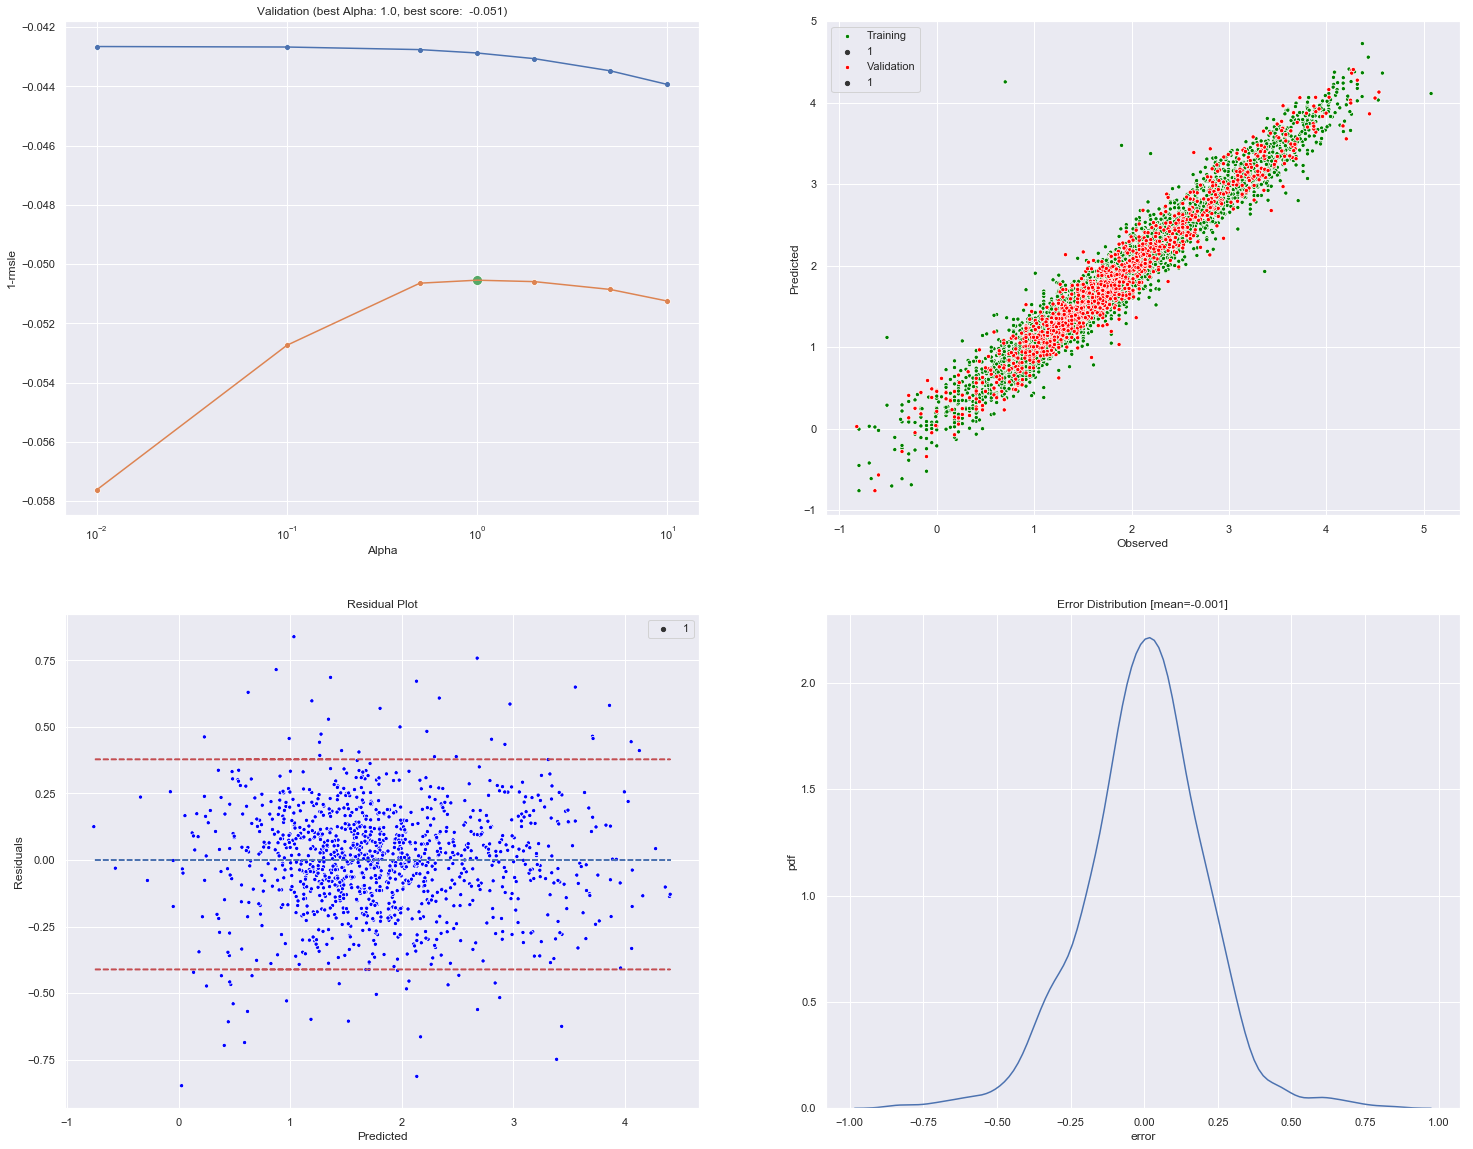

In [41]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__alpha')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best Alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [43]:
model.best_params_,model.best_score_

({'Model_fit__alpha': 1, 'poly_transform__degree': 2}, -0.05054207962191077)

### K-NN

In [15]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('scale', DFStandardScaler()),
    ('Model_fit',KNeighborsRegressor())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [16]:
pipe_params= {'Model_fit__algorithm':['brute','kd_tree'],
              'Model_fit__p':[1,2],
              'Model_fit__n_neighbors':list(range(1,10))}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


ValueError: Found input variables with inconsistent numbers of samples: [2458, 3834]



 Lasso Regression R-Squared: Training = 0.944, Validation = 0.914

 Linear Regression SCORE: Training = 0.961, Validation = 0.943


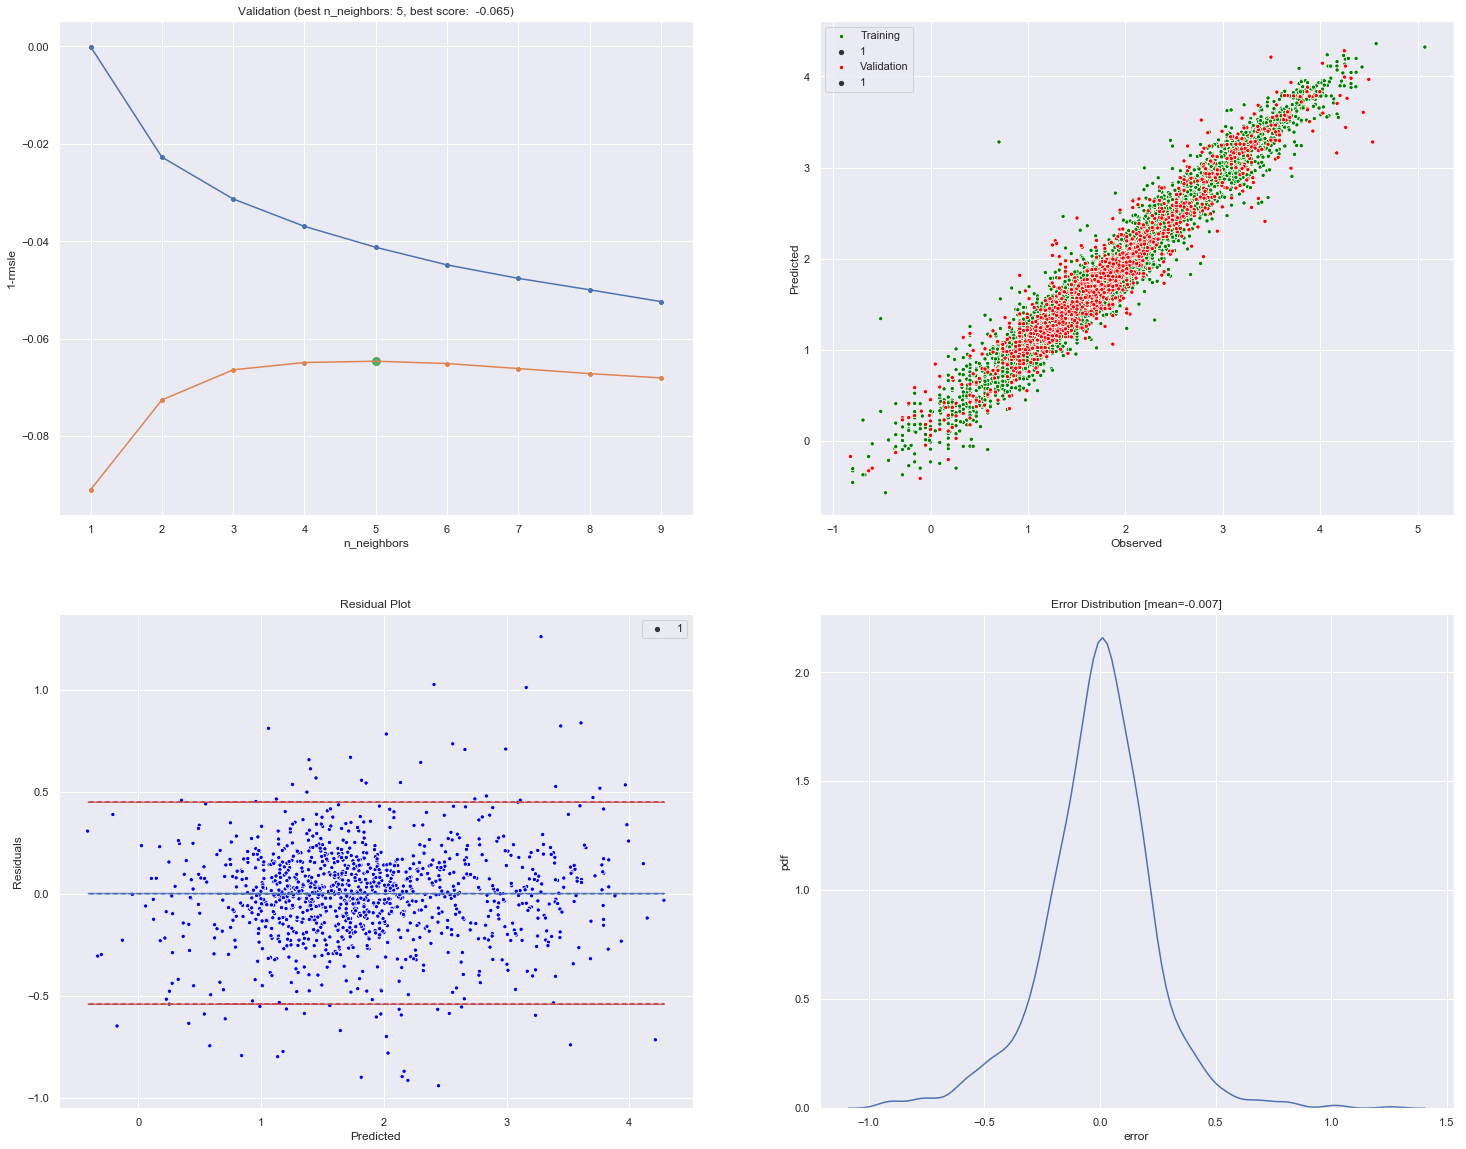

In [48]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__n_neighbors')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__n_neighbors')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
#plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("n_neighbors")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best n_neighbors: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [47]:
model.best_params_,model.best_score_

({'Model_fit__algorithm': 'brute',
  'Model_fit__n_neighbors': 5,
  'Model_fit__p': 1},
 -0.06458459619582681)

### Support Vertors machines

#### Linear SVM

In [56]:
from sklearn.linear_model import SGDRegressor

In [57]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('scale', DFStandardScaler()),
    ('Model_fit',SGDRegressor(loss='epsilon_insensitive'))])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [58]:
pipe_params= {'Model_fit__penalty':['l1','l2'],
              'Model_fit__alpha':[round(0.00001*10**i,6) for i in range(7)]}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.9s finished




 Lasso Regression R-Squared: Training = 0.927, Validation = 0.927

 Linear Regression SCORE: Training = 0.948, Validation = 0.949


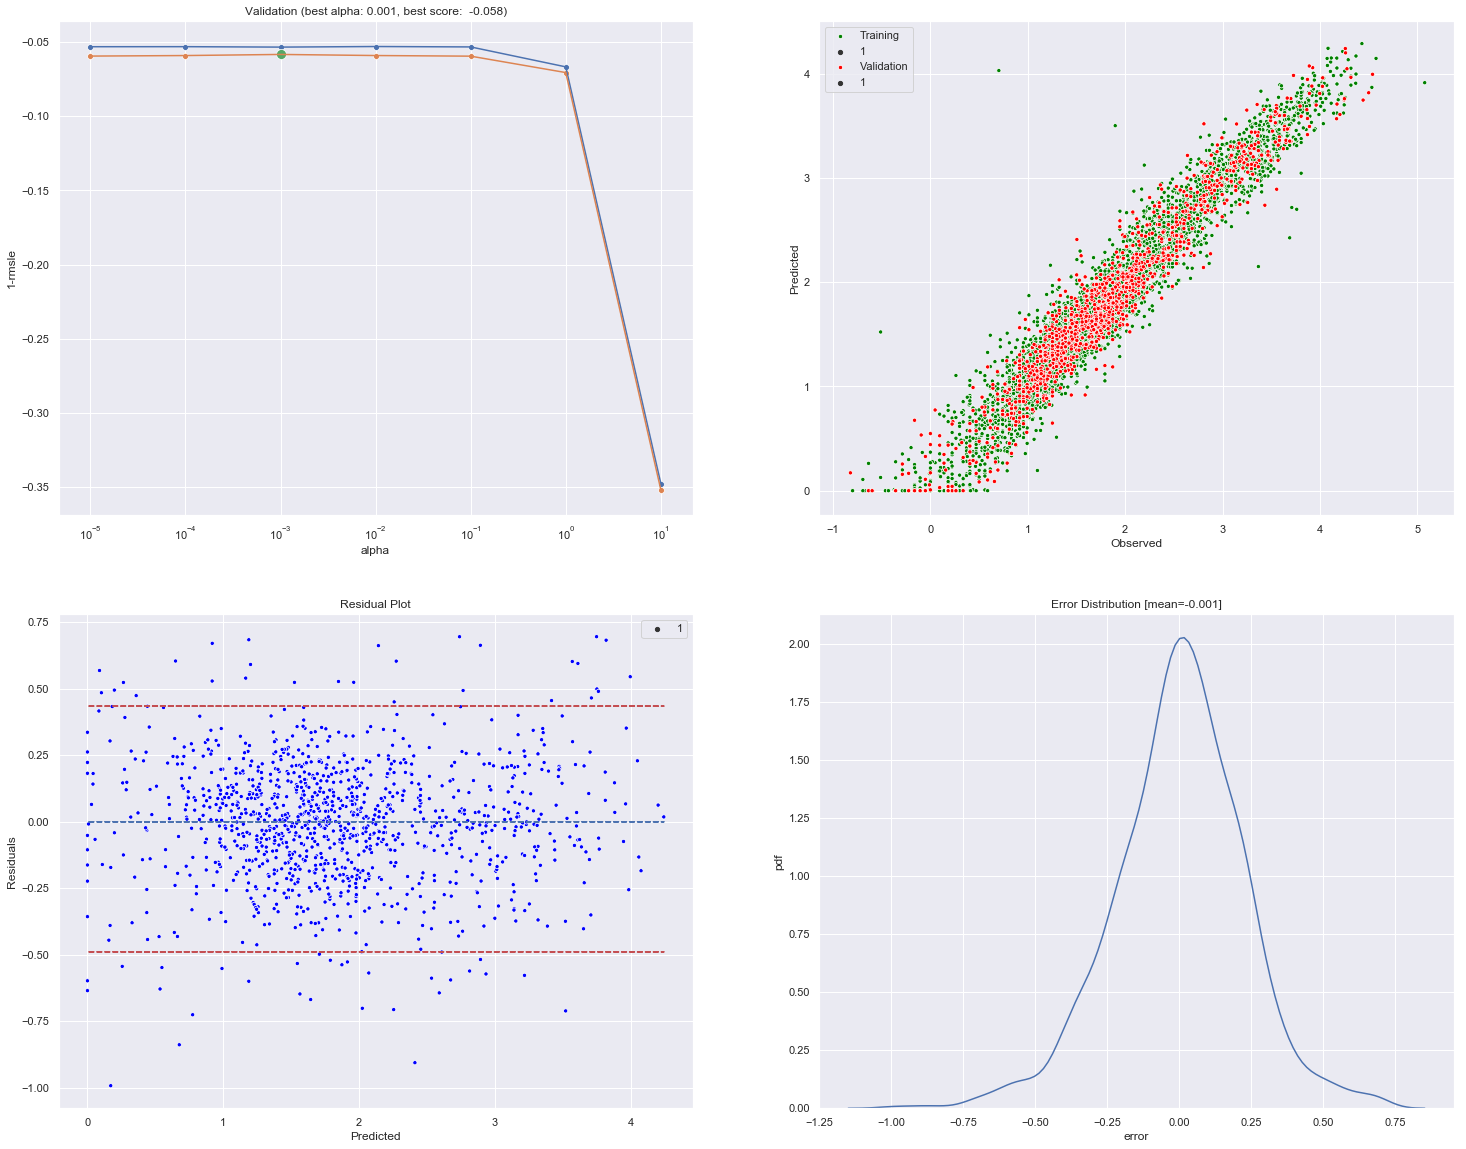

In [59]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__alpha')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("alpha")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [60]:
model.best_params_,model.best_score_

({'Model_fit__alpha': 0.001, 'Model_fit__penalty': 'l1'}, -0.05823898597455414)

#### RBF SVM

In [61]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('scale', DFStandardScaler()),
    ('Model_fit',SVR(kernel='rbf'))])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [62]:
pipe_params= {'Model_fit__C': [round(0.01*10**i,6) for i in range(5)],
              'Model_fit__gamma': [round(0.001*10**i,6) for i in range(6)]}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:   36.2s finished




 Lasso Regression R-Squared: Training = 0.952, Validation = 0.943

 Linear Regression SCORE: Training = 0.966, Validation = 0.96


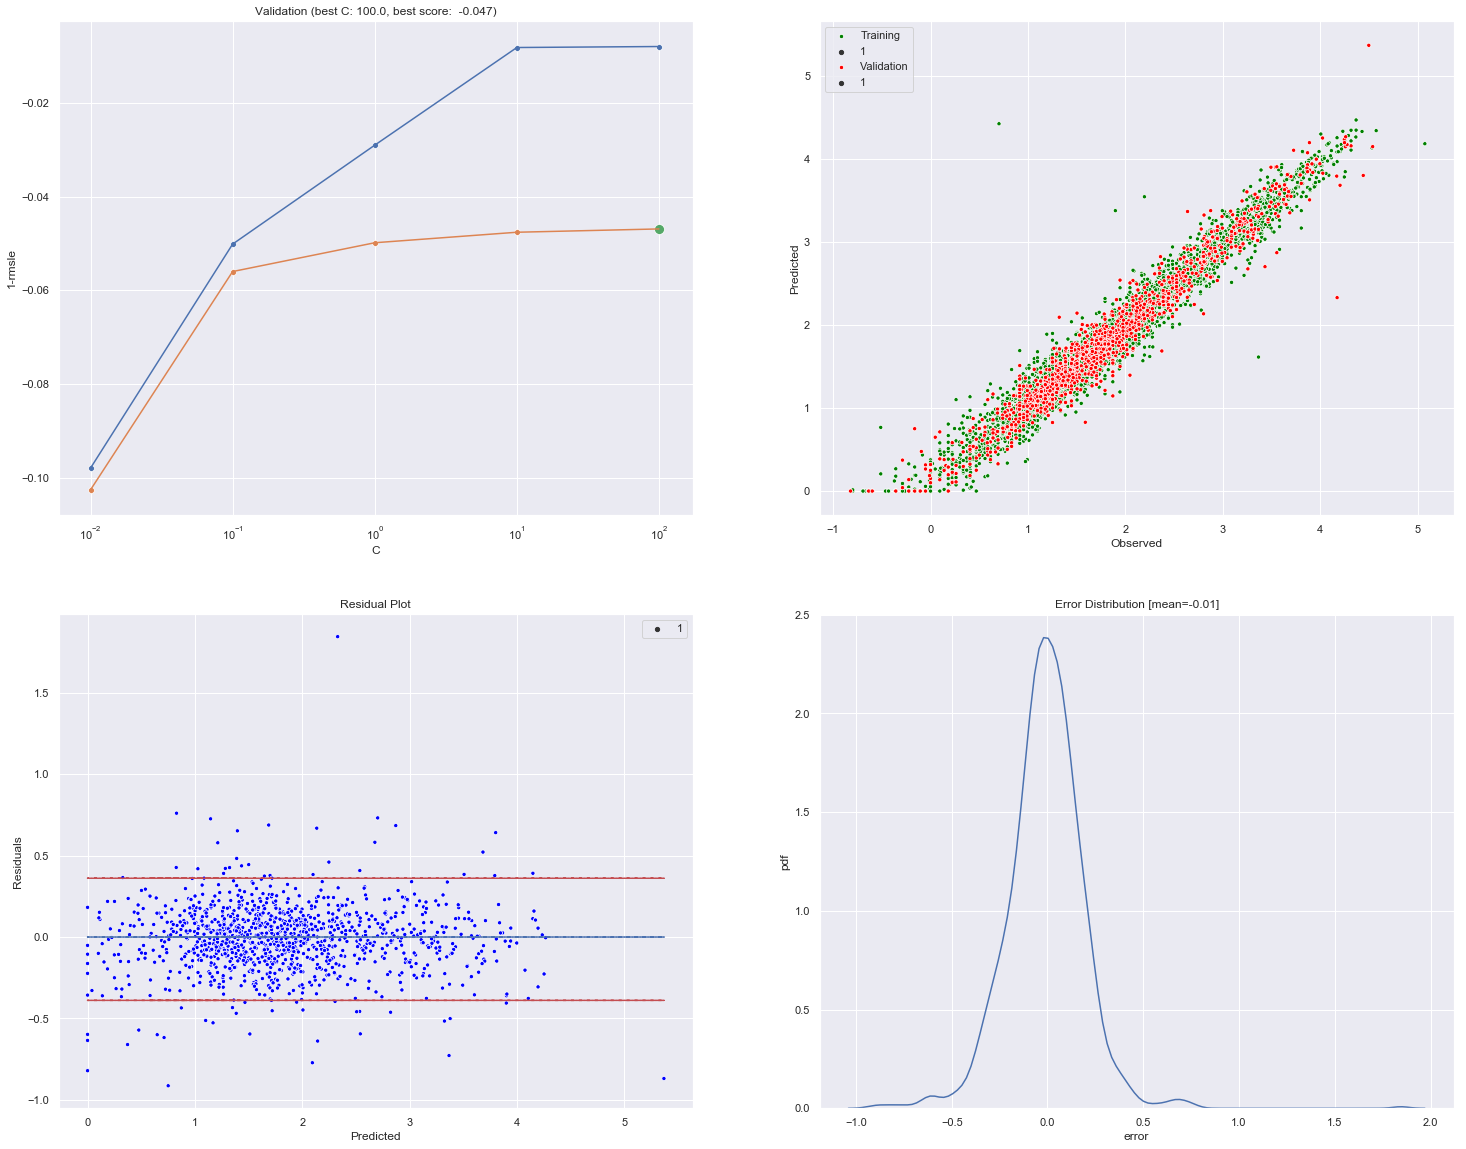

In [63]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__C')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best C: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [66]:
model.best_params_,model.best_score_

({'Model_fit__C': 100.0, 'Model_fit__gamma': 0.01}, -0.04691147132899912)

### Decision Trees

In [67]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('Model_fit',DecisionTreeRegressor())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [68]:
pipe_params= {'Model_fit__max_depth': list(range(3,18,2)),
              'Model_fit__min_samples_split': [5,20,50,100],
              'Model_fit__min_samples_leaf': [5,20,50]
             }


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:   12.4s finished




 Lasso Regression R-Squared: Training = 0.96, Validation = 0.928

 Linear Regression SCORE: Training = 0.971, Validation = 0.95


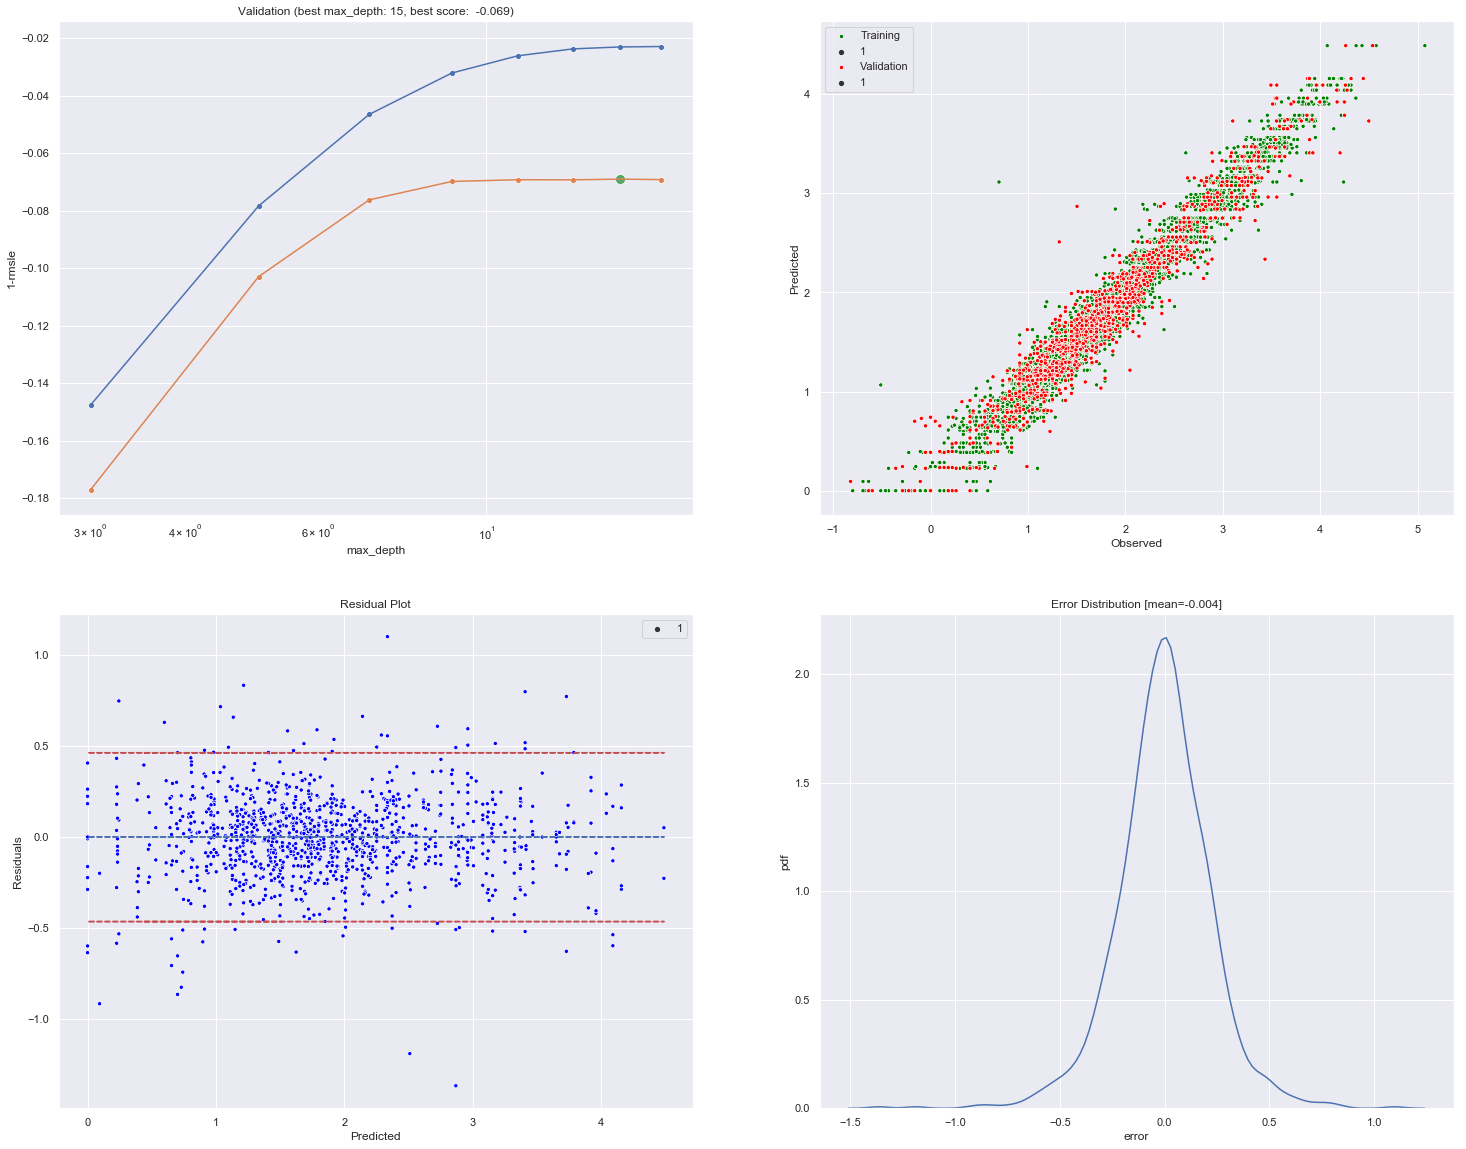

In [69]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__max_depth')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__max_depth')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("max_depth")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best max_depth: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [70]:
model.best_params_,model.best_score_

({'Model_fit__max_depth': 15,
  'Model_fit__min_samples_leaf': 5,
  'Model_fit__min_samples_split': 20},
 -0.06905192352644629)

### Random Forest

In [71]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('Model_fit',RandomForestRegressor())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [72]:
pipe_params= {
    'Model_fit__n_estimators':[20,40,80,100,120,150],
    'Model_fit__min_samples_split':[20,40,60],
    'Model_fit__max_depth':[4,6,8],
    'Model_fit__min_samples_leaf':[20,40,60],
}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   17.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   44.8s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 810 out of 810 | elapsed:  1.5min finished




 Lasso Regression R-Squared: Training = 0.94, Validation = 0.927

 Linear Regression SCORE: Training = 0.958, Validation = 0.951


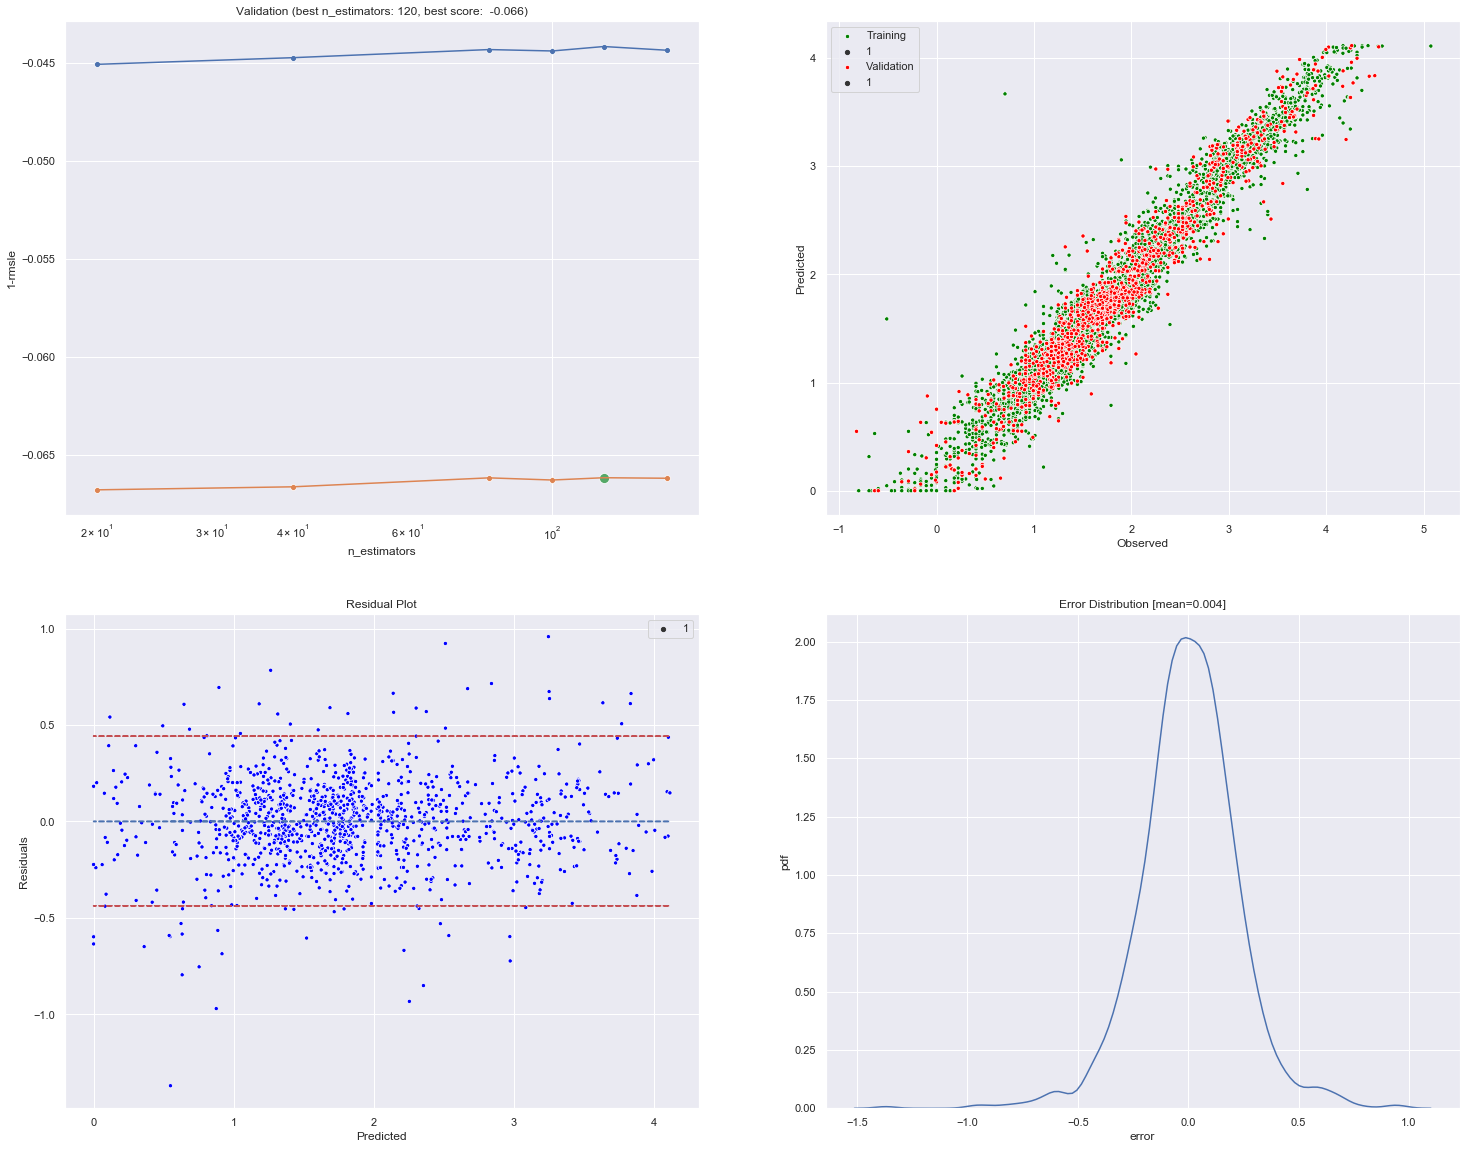

In [73]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__n_estimators')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__n_estimators')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("n_estimators")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best n_estimators: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [74]:
model.best_params_,model.best_score_

({'Model_fit__max_depth': 8,
  'Model_fit__min_samples_leaf': 20,
  'Model_fit__min_samples_split': 40,
  'Model_fit__n_estimators': 120},
 -0.06616303227070647)

### GBDT

In [18]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('Model_fit',GradientBoostingRegressor())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [25]:
pipe_params= {
    'Model_fit__n_estimators': [100,150,200,250,500], #[10,50,100,150,200,250,500,750]
    'Model_fit__learning_rate': [0.01,0.1,0.5,1],
    'Model_fit__subsample': [0.1,0.2,0.5,1.0],
}


model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   17.6s
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:   38.4s finished




 Lasso Regression R-Squared: Training = 0.98, Validation = 0.965

 Linear Regression SCORE: Training = 0.985, Validation = 0.975


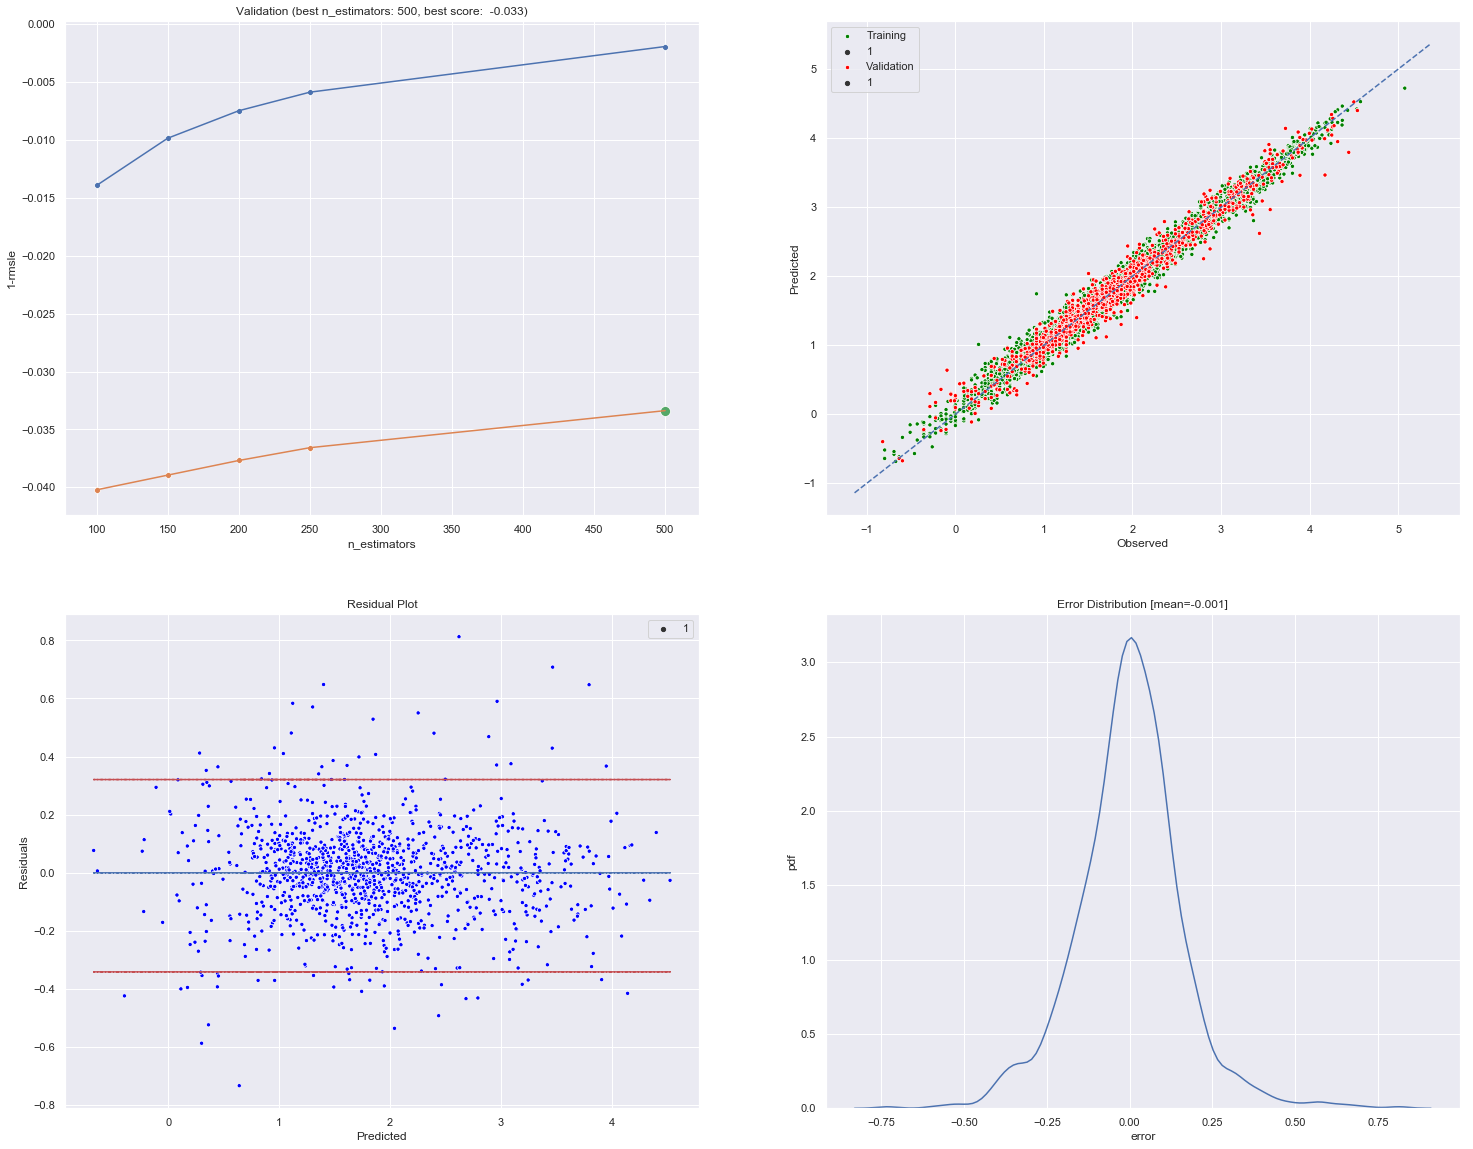

In [28]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

#vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__n_estimators')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__n_estimators')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
#plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("n_estimators")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best n_estimators: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
x = np.linspace(*plt.xlim())
plt.plot(x, x,'b--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [27]:
model.best_params_,model.best_score_

({'Model_fit__learning_rate': 0.1,
  'Model_fit__n_estimators': 500,
  'Model_fit__subsample': 0.5},
 -0.03337405188237081)

#### retrain GBDT

In [50]:
GBM_Regressor = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('Model_fit',GradientBoostingRegressor())])

best_par = {
    'Model_fit__learning_rate': 0.1,
    'Model_fit__n_estimators': 500,
    'Model_fit__subsample': 0.5
}

GBM_Regressor.set_params(**best_par)
GBM_Regressor.fit(X_train,y=np.log(y_train));



 Lasso Regression R-Squared: Training = 0.98, Validation = 0.964

 Linear Regression SCORE: Training = 0.985, Validation = 0.974


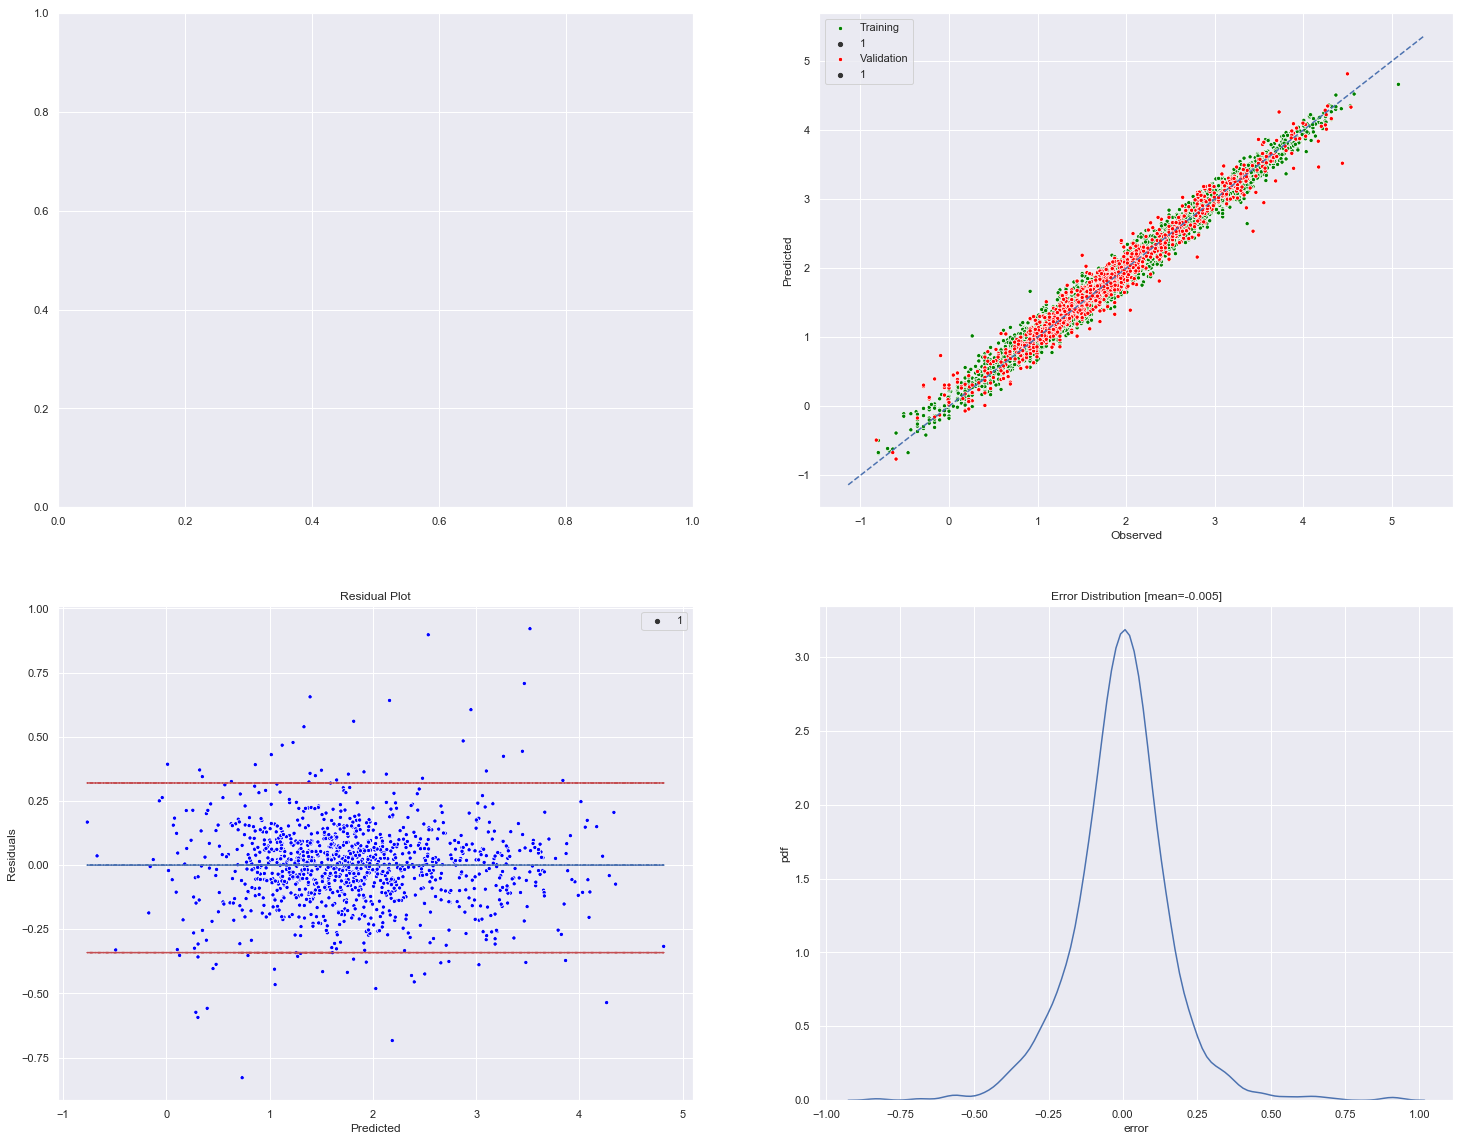

In [52]:
### 
train_pred_y = GBM_Regressor.predict(X_train)
test_pred_y = GBM_Regressor.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
#results = pd.DataFrame(GBM_Regressor.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__n_estimators')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__n_estimators')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
# #plt.xscale('log')

# sns.lineplot(mean_train_score.index,mean_train_score)
# sns.lineplot(mean_test_score.index,mean_test_score)

# sns.scatterplot(mean_train_score.index,mean_train_score)
# sns.scatterplot(mean_test_score.index,mean_test_score)
# max_ind = mean_test_score.argmax()
# sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

# plt.xlabel("n_estimators")
# plt.ylabel("1-rmsle")
# plt.title(f"Validation (best n_estimators: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training');
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation');
x = np.linspace(*plt.xlim())
plt.plot(x, x,'b--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [48]:
model.get_params()

{'memory': None,
 'steps': [('features',
   DFFeatureUnion(transformer_list=[('numerics', Pipeline(memory=None,
        steps=[('extract', ColumnExtractor(cols=['Kilometers_Driven', 'Mileage', 'Engine', 'Power'])), ('log', Log1pTransformer()), ('col_Interact', DFadd_ColInteraction(col1='Kilometers_Driven', col2='Mileage'))])), ('nominal_OneHot', Pipeline(memor...t', ColumnExtractor(cols=['Seats'])), ('Select_OneHot', DF_OneHotEncoder(filter_threshold=0.05))]))])),
  ('Model_fit',
   GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_impurity_split=None, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=500, n_iter_no_change=None, presort='auto',
                random_state=None, subsample=0.5, tol=0.0001,
                validation_fracti

### XGBoost

In [13]:
pipeline = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage'))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats)),
            ('Select_OneHot',DF_OneHotEncoder(filter_threshold=0.05))]))
        ])),
    ('Model_fit',xgb.XGBRFRegressor())])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

In [19]:
pipe_params = {
    "Model_fit__learning_rate": [0.05, 0.10, 0.5, 1,1.5],
    "Model_fit__min_child_weight": [1, 3, 5, 7],
    "Model_fit__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "Model_fit__colsample_bytree": [0.3,0.5,1],
    "Model_fit__subsample": [0.5, 0.7,1],
    "Model_fit__n_estimators": [100, 150, 250,500]
}

model = GridSearchCV(pipeline,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 6,
                        cv = 5,verbose=1,return_train_score= True)
model.fit(X_train,y=np.log(y_train));

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   23.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   45.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 19.3mi



 Lasso Regression R-Squared: Training = 0.936, Validation = 0.921

 Linear Regression SCORE: Training = 0.957, Validation = 0.948


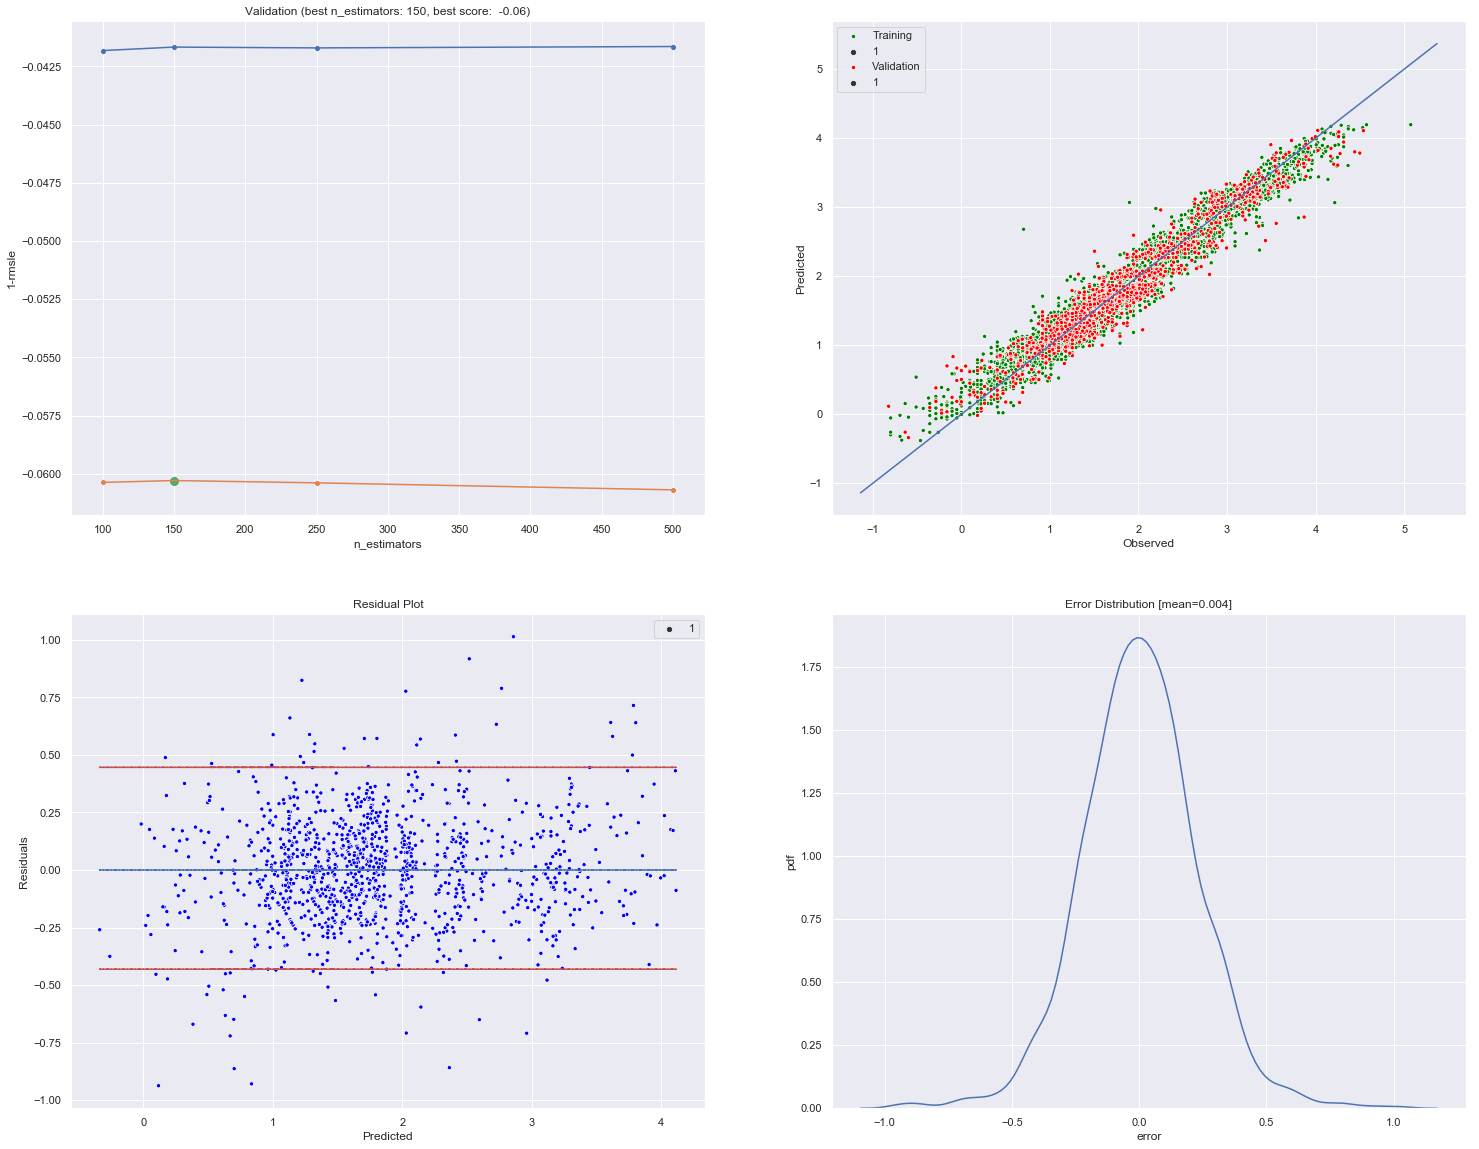

In [30]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Lasso Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {1-round(score(np.log(y_train),train_pred_y),3)}, Validation = {1-round(score(np.log(y_test),test_pred_y),3)}")




#          *********** Plot validation and Residuals  ********
results = pd.DataFrame(model.cv_results_)
err = np.log(y_test)-test_pred_y

mean_train_score = results.groupby('param_Model_fit__n_estimators')['mean_train_score'].max()
mean_test_score = results.groupby('param_Model_fit__n_estimators')['mean_test_score'].max()

plt.figure(figsize=(25,20))
plt.subplot(221)
#plt.xscale('log')

sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("n_estimators")
plt.ylabel("1-rmsle")
plt.title(f"Validation (best n_estimators: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


plt.subplot(222)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training')
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation')
x = np.linspace(*plt.xlim())
plt.plot(x, x)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend();


plt.subplot(223)
p5, p95= np.round(np.percentile(err, [2.5, 97.5]),3)
sns.scatterplot(test_pred_y,(err) ,size=1, color = 'blue')
plt.plot(test_pred_y,[0]*len(test_pred_y), 'b--')
plt.plot(test_pred_y,[p5]*len(test_pred_y), 'r--') 
plt.plot(test_pred_y,[p95]*len(test_pred_y), 'r--') 

plt.title('Residual Plot')
plt.xlabel('Predicted');
plt.ylabel('Residuals');

plt.subplot(224)
sns.distplot((err), hist= False)
plt.title(f'Error Distribution [mean={round(np.mean(err),3)}]')
plt.xlabel('error');
plt.ylabel('pdf');

In [21]:
model.best_params_,model.best_score_

({'Model_fit__colsample_bytree': 1,
  'Model_fit__gamma': 0.1,
  'Model_fit__learning_rate': 1,
  'Model_fit__min_child_weight': 1,
  'Model_fit__n_estimators': 150,
  'Model_fit__subsample': 0.5},
 -0.06028688182230081)

In [18]:
with open('XGBoost.pkl','wb') as f:
    pickle.dump(model, f, 2)

## Preparing Inputs for  Model Deployment

In [53]:
with open('GBM_Regressor_pipeline.pkl','wb') as f:
    pickle.dump(GBM_Regressor, f, 2)

In [39]:
with open('GBM_Regressor_pipeline.pkl','rb') as f:
    GBM_Regressor = pickle.load(f)

In [13]:

le = defaultdict(LabelEncoder)

In [50]:
with open('gbm_model_dump.pkl', 'wb') as f:
    pickle.dump(model, f, 2)

In [25]:
with open('gbm_model_dump.pkl', 'rb') as f:
    model = pickle.load(f)

In [27]:
X_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
Brand                6019 non-null int64
Model                6019 non-null int64
Location             6019 non-null int64
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null int64
Transmission         6019 non-null int64
Owner_Type           6019 non-null int64
Mileage              6019 non-null float64
Engine               6019 non-null float64
Power                6019 non-null float64
Seats                6019 non-null float64
dtypes: float64(4), int64(8)
memory usage: 564.4 KB


### segregate categories and int

In [26]:
# columns groups based on dypes int(represents discrete and categories vs float)
int_cols = list(X_train_data.select_dtypes(include='int'))
int_cols.remove('Kilometers_Driven')
float_cols = list(X_train_data.select_dtypes(include='float'))+['Kilometers_Driven']

In [31]:
X_train_data.describe()

Brand        Model     Location         Year  Kilometers_Driven  \
count  6019.000000  6019.000000  6019.000000  6019.000000       6.019000e+03   
mean     16.382123   113.415684     5.619704  2013.358199       5.873838e+04   
std       8.594181    67.382592     2.955933     3.269742       9.126884e+04   
min       0.000000     0.000000     0.000000  1998.000000       1.710000e+02   
25%      10.000000    54.000000     3.000000  2011.000000       3.400000e+04   
50%      18.000000   103.000000     6.000000  2014.000000       5.300000e+04   
75%      20.000000   176.000000     8.000000  2016.000000       7.300000e+04   
max      32.000000   218.000000    10.000000  2019.000000       6.500000e+06   

         Fuel_Type  Transmission   Owner_Type      Mileage       Engine  \
count  6019.000000   6019.000000  6019.000000  6019.000000  6019.000000   
mean      2.363017      0.714238     0.379465    18.134584  1618.738827   
std       1.504939      0.451814     0.818458     4.581574   600.445858   
min       0.000000      0.000000     0.000000     0.000000    72.000000   
25%       1.000000      0.000000     0.000000    15.170000  1197.000000   
50%       1.000000      1.000000     0.000000    18.150000  1493.000000   
75%       4.000000      1.000000     0.000000    21.100000  1969.000000   
max       4.000000      1.000000     3.000000    33.540000  5998.000000   

             Power        Seats  
count  6019.000000  6019.000000  
mean    112.320472     5.276790  
std      53.565700     0.806346  
min      34.200000     0.000000  
25%      74.000000     5.000000  
50%      91.100000     5.000000  
75%     138.030000     5.000000  
max     560.000000    10.000000

### Min, Max and Default values for variables

In [67]:
# Get default values to show for app is run the first and stores them in dictionary to 
# get mapping


default_dict = dict()
min_dict = dict()
max_dict = dict()



for col in list(X_train_data):
    if col in int_cols:
        exec("default_"+col + " =  stats.mode(X_train_data[col]).mode")
        exec("min_"+col + " =  np.min(X_train_data[col])")
        exec("max_"+col + " =  np.max(X_train_data[col])")
        exec("default_dict['"+col+"']  =  default_"+col+".item()")
        exec("min_dict['"+col+"']  =  min_"+col)
        exec("max_dict['"+col+"']  =  max_"+col)
    if col in float_cols:
        exec("default_"+col + " =  np.mean(X_train_data[col].values,keepdims=True)")
        exec("min_"+col + " =  np.min(X_train_data[col])")
        exec("max_"+col + " =  np.max(X_train_data[col])")
        exec("default_dict['"+col+"']  =  default_"+col+".item()")
        exec("min_dict['"+col+"']  =  min_"+col)
        exec("max_dict['"+col+"']  =  max_"+col)

default_dict['Brand']
default_dict['Model']
default_dict['Location']
default_dict['Year']
default_dict['Fuel_Type']
default_dict['Transmission']
default_dict['Owner_Type']


### Look at default values label encoded tranformed back to categories

In [91]:
default_dict_mapped

{'Brand': array(['Maruti'], dtype='<U13'),
 'Model': array(['Swift'], dtype='<U11'),
 'Location': array(['Mumbai'], dtype='<U10'),
 'Fuel_Type': array(['Diesel'], dtype='<U8'),
 'Transmission': array(['Manual'], dtype='<U9'),
 'Owner_Type': array(['First'], dtype='<U14')}

In [90]:
# mapping Dictionary for default values
default_dict_mapped = dict()
default_dict_mapped['Brand'] = le_brands.inverse_transform([default_dict['Brand']])
default_dict_mapped['Model'] = le_models.inverse_transform([default_dict['Model']])
default_dict_mapped['Location'] = le_locations.inverse_transform([default_dict['Location']])
default_dict_mapped['Fuel_Type'] = le_fuel_types.inverse_transform([default_dict['Fuel_Type']])
default_dict_mapped['Transmission'] = le_transmissions.inverse_transform([default_dict['Transmission']])
default_dict_mapped['Owner_Type'] = le_owner_types.inverse_transform([default_dict['Owner_Type']])


In [19]:
# Create Encoded dictionaries that store encoded mapping

encoders = ['le_brands','le_models','le_locations','le_fuel_types','le_transmissions','le_owner_types']

for i in encoders:
    print(i+"_Encdict")
    exec(i+"_Encdict = dict(zip("+i+".classes_, "+i+".transform("+i+".classes_)))")

le_brands_Encdict
le_models_Encdict
le_locations_Encdict
le_fuel_types_Encdict
le_transmissions_Encdict
le_owner_types_Encdict


### Let's put all dictictiories in list 

### min, max, default values to categories mapping dictionary 

In [93]:
Dicts = [default_dict,min_dict, max_dict, default_dict_mapped]

In [94]:
with open('Dictionaries.pkl', 'wb') as f:
    pickle.dump(Dicts, f, 2)

### Encoded values to categories mapping dictionary 

In [21]:
Encoded_dicts = [le_brands_Encdict,le_models_Encdict,le_locations_Encdict,le_fuel_types_Encdict,le_transmissions_Encdict,le_owner_types_Encdict]

In [22]:
with open('Encoded_dicts.pkl','wb') as f:
    pickle.dump(Encoded_dicts, f, 2)

In [67]:
# min, max, default values to categories mapping dictionary
with open('Dictionaries.pkl', 'rb') as f:
    default_dict,min_dict, max_dict, default_dict_mapped= pickle.load(f)

# Encoded values to categories mapping dictionary
with open('Encoded_dicts.pkl', 'rb') as f:

    

### Model to brand mapping dictionary model2brand

In [60]:
model2brand

{'Ambassador': ['Classic'],
 'Audi': ['Q3', 'A7', 'A4', 'A8', 'RS5', 'Q7', 'A6', 'A3', 'TT', 'Q5'],
 'BMW': ['5', 'X3', 'Z4', '1', 'X5', '7', 'X1', '3', 'X6', '6'],
 'Bentley': ['Continental'],
 'Chevrolet': ['Sail',
  'Optra',
  'Beat',
  'Captiva',
  'Spark',
  'Tavera',
  'Enjoy',
  'Cruze',
  'Aveo'],
 'Datsun': ['redi-GO', 'Redi', 'GO'],
 'Fiat': ['Siena', 'Punto', 'Avventura', 'Grande', 'Petra', 'Linea'],
 'Force': ['One'],
 'Ford': ['Aspire',
  'Mustang',
  'Fusion',
  'EcoSport',
  'Endeavour',
  'Freestyle',
  'Figo',
  'Classic',
  'Ecosport',
  'Fiesta',
  'Ikon'],
 'Honda': ['Jazz',
  'CR-V',
  'WRV',
  'BR-V',
  'Amaze',
  'WR-V',
  'Mobilio',
  'City',
  'Civic',
  'Accord',
  'Brio',
  'BRV'],
 'Hyundai': ['Elantra',
  'Tucson',
  'Santa',
  'i20',
  'Santro',
  'i10',
  'Getz',
  'Grand',
  'Creta',
  'Xcent',
  'EON',
  'Verna',
  'Elite',
  'Accent',
  'Sonata'],
 'ISUZU': ['D-MAX'],
 'Isuzu': ['MUX'],
 'Jaguar': ['F', 'XJ', 'XE', 'XF'],
 'Jeep': ['Compass'],
 'Lambor

In [61]:
with open('model2brand.pkl','wb') as f:
    pickle.dump(model2brand, f, 2)

In [9]:
with open('gbm_model_dump.pkl', 'rb') as f:
        gbm_model = pickle.load(f)

In [2]:
min_dict

{'Brand': 0,
 'Model': 0,
 'Location': 0,
 'Year': 1998,
 'Kilometers_Driven': 171,
 'Fuel_Type': 0,
 'Transmission': 0,
 'Owner_Type': 0,
 'Mileage': 0.0,
 'Engine': 72.0,
 'Power': 34.2,
 'Seats': 0.0}

In [11]:
default_dict

{'Brand': 19,
 'Model': 176,
 'Location': 9,
 'Year': 2014,
 'Kilometers_Driven': 58738.38029573019,
 'Fuel_Type': 1,
 'Transmission': 1,
 'Owner_Type': 0,
 'Mileage': 18.134583817909952,
 'Engine': 1618.7388270476824,
 'Power': 112.32047183917594,
 'Seats': 5.2767901644791495}

In [3]:
max_dict

{'Brand': 32,
 'Model': 218,
 'Location': 10,
 'Year': 2019,
 'Kilometers_Driven': 6500000,
 'Fuel_Type': 4,
 'Transmission': 1,
 'Owner_Type': 3,
 'Mileage': 33.54,
 'Engine': 5998.0,
 'Power': 560.0,
 'Seats': 10.0}

In [16]:
from flask import Flask, render_template, flash, request, jsonify

In [2]:
le_brands_Encdict

{'Ambassador': 0,
 'Audi': 1,
 'BMW': 2,
 'Bentley': 3,
 'Chevrolet': 4,
 'Datsun': 5,
 'Fiat': 6,
 'Force': 7,
 'Ford': 8,
 'Hindustan': 9,
 'Honda': 10,
 'Hyundai': 11,
 'ISUZU': 12,
 'Isuzu': 13,
 'Jaguar': 14,
 'Jeep': 15,
 'Lamborghini': 16,
 'Land': 17,
 'Mahindra': 18,
 'Maruti': 19,
 'Mercedes-Benz': 20,
 'Mini': 21,
 'Mitsubishi': 22,
 'Nissan': 23,
 'OpelCorsa': 24,
 'Porsche': 25,
 'Renault': 26,
 'Skoda': 27,
 'Smart': 28,
 'Tata': 29,
 'Toyota': 30,
 'Volkswagen': 31,
 'Volvo': 32}

In [65]:
del le_owner_types_Encdict

In [68]:
le_owner_types_Encdict

{'First': 0, 'Fourth & Above': 1, 'Second': 2, 'Third': 3}